# AudioCLIP Guided Diffusion with Inter-Modal Augmentation and Image Captioning



This project is a modification of the original **Clip Guided Diffusion** notebook by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). It uses **OpenAI's 256x256 unconditional ImageNet diffusion model** (https://github.com/openai/guided-diffusion) together with **AudioCLIP** (https://github.com/AndreyGuzhov/AudioCLIP) to generate images from **text prompts** and **audio prompts**. 

The AudioCLIP model used is the pretrained version which keeps the default image head and text head weights from the ResNET version of CLIP (RN50). This allows vanilla CLIP to be loaded into cuda and used at generation time to create image embeddings as opposed to AudioCLIP which requires twice the amount of memory.

It also features the follow:

1. a form of automatic text prompt engineering by incorporating two types of audio description mechanisms:
  - Description via an audioCLIP-based querying of keywords.
  - Description via a manually-trained music captioning model ([MusCaps](https://github.com/ilaria-manco/muscaps ) model trained on the [Clotho](https://arxiv.org/abs/1910.09387) dataset).

  These can be ran on the uploaded audio file to generate descriptions that can be used to enrich the audio prompts during generation time.

2. An image captioning mechanism in the form of ClipCap, a lightweight prefix-based model that binds GPT2 and the vision transformer (ViT) version of clip to produce a caption for each generated image.

The original notebook can be found here: https://colab.research.google.com/drive/12a_Wrfi2_gwwAuN3VvMTwVMz9TfqctNj







In [ ]:
# @title Licenses 

#=========================================================#
# Original Notebook: CLIP Guided Diffusion HQ 256x256.ipynb
#=========================================================#

# MIT License
# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.



#=========================================================#
# AudioCLIP
#=========================================================#

# MIT License
# Copyright (c) 2021 Andrey Guzhov
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

#=======#
# CLIPCap
#=======#

# MIT License
# Copyright (c) 2021 rmokady

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

#========#
# MusCaps
#========#

#                     GNU GENERAL PUBLIC LICENSE
#                        Version 3, 29 June 2007

#  Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
#  Everyone is permitted to copy and distribute verbatim copies
#  of this license document, but changing it is not allowed.

#                             Preamble

#   The GNU General Public License is a free, copyleft license for
# software and other kinds of works.

#   The licenses for most software and other practical works are designed
# to take away your freedom to share and change the works.  By contrast,
# the GNU General Public License is intended to guarantee your freedom to
# share and change all versions of a program--to make sure it remains free
# software for all its users.  We, the Free Software Foundation, use the
# GNU General Public License for most of our software; it applies also to
# any other work released this way by its authors.  You can apply it to
# your programs, too.

#   When we speak of free software, we are referring to freedom, not
# price.  Our General Public Licenses are designed to make sure that you
# have the freedom to distribute copies of free software (and charge for
# them if you wish), that you receive source code or can get it if you
# want it, that you can change the software or use pieces of it in new
# free programs, and that you know you can do these things.

#   To protect your rights, we need to prevent others from denying you
# these rights or asking you to surrender the rights.  Therefore, you have
# certain responsibilities if you distribute copies of the software, or if
# you modify it: responsibilities to respect the freedom of others.

#   For example, if you distribute copies of such a program, whether
# gratis or for a fee, you must pass on to the recipients the same
# freedoms that you received.  You must make sure that they, too, receive
# or can get the source code.  And you must show them these terms so they
# know their rights.

#   Developers that use the GNU GPL protect your rights with two steps:
# (1) assert copyright on the software, and (2) offer you this License
# giving you legal permission to copy, distribute and/or modify it.

#   For the developers' and authors' protection, the GPL clearly explains
# that there is no warranty for this free software.  For both users' and
# authors' sake, the GPL requires that modified versions be marked as
# changed, so that their problems will not be attributed erroneously to
# authors of previous versions.

#   Some devices are designed to deny users access to install or run
# modified versions of the software inside them, although the manufacturer
# can do so.  This is fundamentally incompatible with the aim of
# protecting users' freedom to change the software.  The systematic
# pattern of such abuse occurs in the area of products for individuals to
# use, which is precisely where it is most unacceptable.  Therefore, we
# have designed this version of the GPL to prohibit the practice for those
# products.  If such problems arise substantially in other domains, we
# stand ready to extend this provision to those domains in future versions
# of the GPL, as needed to protect the freedom of users.

#   Finally, every program is threatened constantly by software patents.
# States should not allow patents to restrict development and use of
# software on general-purpose computers, but in those that do, we wish to
# avoid the special danger that patents applied to a free program could
# make it effectively proprietary.  To prevent this, the GPL assures that
# patents cannot be used to render the program non-free.

#   The precise terms and conditions for copying, distribution and
# modification follow.

#                        TERMS AND CONDITIONS

#   0. Definitions.

#   "This License" refers to version 3 of the GNU General Public License.

#   "Copyright" also means copyright-like laws that apply to other kinds of
# works, such as semiconductor masks.

#   "The Program" refers to any copyrightable work licensed under this
# License.  Each licensee is addressed as "you".  "Licensees" and
# "recipients" may be individuals or organizations.

#   To "modify" a work means to copy from or adapt all or part of the work
# in a fashion requiring copyright permission, other than the making of an
# exact copy.  The resulting work is called a "modified version" of the
# earlier work or a work "based on" the earlier work.

#   A "covered work" means either the unmodified Program or a work based
# on the Program.

#   To "propagate" a work means to do anything with it that, without
# permission, would make you directly or secondarily liable for
# infringement under applicable copyright law, except executing it on a
# computer or modifying a private copy.  Propagation includes copying,
# distribution (with or without modification), making available to the
# public, and in some countries other activities as well.

#   To "convey" a work means any kind of propagation that enables other
# parties to make or receive copies.  Mere interaction with a user through
# a computer network, with no transfer of a copy, is not conveying.

#   An interactive user interface displays "Appropriate Legal Notices"
# to the extent that it includes a convenient and prominently visible
# feature that (1) displays an appropriate copyright notice, and (2)
# tells the user that there is no warranty for the work (except to the
# extent that warranties are provided), that licensees may convey the
# work under this License, and how to view a copy of this License.  If
# the interface presents a list of user commands or options, such as a
# menu, a prominent item in the list meets this criterion.

#   1. Source Code.

#   The "source code" for a work means the preferred form of the work
# for making modifications to it.  "Object code" means any non-source
# form of a work.

#   A "Standard Interface" means an interface that either is an official
# standard defined by a recognized standards body, or, in the case of
# interfaces specified for a particular programming language, one that
# is widely used among developers working in that language.

#   The "System Libraries" of an executable work include anything, other
# than the work as a whole, that (a) is included in the normal form of
# packaging a Major Component, but which is not part of that Major
# Component, and (b) serves only to enable use of the work with that
# Major Component, or to implement a Standard Interface for which an
# implementation is available to the public in source code form.  A
# "Major Component", in this context, means a major essential component
# (kernel, window system, and so on) of the specific operating system
# (if any) on which the executable work runs, or a compiler used to
# produce the work, or an object code interpreter used to run it.

#   The "Corresponding Source" for a work in object code form means all
# the source code needed to generate, install, and (for an executable
# work) run the object code and to modify the work, including scripts to
# control those activities.  However, it does not include the work's
# System Libraries, or general-purpose tools or generally available free
# programs which are used unmodified in performing those activities but
# which are not part of the work.  For example, Corresponding Source
# includes interface definition files associated with source files for
# the work, and the source code for shared libraries and dynamically
# linked subprograms that the work is specifically designed to require,
# such as by intimate data communication or control flow between those
# subprograms and other parts of the work.

#   The Corresponding Source need not include anything that users
# can regenerate automatically from other parts of the Corresponding
# Source.

#   The Corresponding Source for a work in source code form is that
# same work.

#   2. Basic Permissions.

#   All rights granted under this License are granted for the term of
# copyright on the Program, and are irrevocable provided the stated
# conditions are met.  This License explicitly affirms your unlimited
# permission to run the unmodified Program.  The output from running a
# covered work is covered by this License only if the output, given its
# content, constitutes a covered work.  This License acknowledges your
# rights of fair use or other equivalent, as provided by copyright law.

#   You may make, run and propagate covered works that you do not
# convey, without conditions so long as your license otherwise remains
# in force.  You may convey covered works to others for the sole purpose
# of having them make modifications exclusively for you, or provide you
# with facilities for running those works, provided that you comply with
# the terms of this License in conveying all material for which you do
# not control copyright.  Those thus making or running the covered works
# for you must do so exclusively on your behalf, under your direction
# and control, on terms that prohibit them from making any copies of
# your copyrighted material outside their relationship with you.

#   Conveying under any other circumstances is permitted solely under
# the conditions stated below.  Sublicensing is not allowed; section 10
# makes it unnecessary.

#   3. Protecting Users' Legal Rights From Anti-Circumvention Law.

#   No covered work shall be deemed part of an effective technological
# measure under any applicable law fulfilling obligations under article
# 11 of the WIPO copyright treaty adopted on 20 December 1996, or
# similar laws prohibiting or restricting circumvention of such
# measures.

#   When you convey a covered work, you waive any legal power to forbid
# circumvention of technological measures to the extent such circumvention
# is effected by exercising rights under this License with respect to
# the covered work, and you disclaim any intention to limit operation or
# modification of the work as a means of enforcing, against the work's
# users, your or third parties' legal rights to forbid circumvention of
# technological measures.

#   4. Conveying Verbatim Copies.

#   You may convey verbatim copies of the Program's source code as you
# receive it, in any medium, provided that you conspicuously and
# appropriately publish on each copy an appropriate copyright notice;
# keep intact all notices stating that this License and any
# non-permissive terms added in accord with section 7 apply to the code;
# keep intact all notices of the absence of any warranty; and give all
# recipients a copy of this License along with the Program.

#   You may charge any price or no price for each copy that you convey,
# and you may offer support or warranty protection for a fee.

#   5. Conveying Modified Source Versions.

#   You may convey a work based on the Program, or the modifications to
# produce it from the Program, in the form of source code under the
# terms of section 4, provided that you also meet all of these conditions:

#     a) The work must carry prominent notices stating that you modified
#     it, and giving a relevant date.

#     b) The work must carry prominent notices stating that it is
#     released under this License and any conditions added under section
#     7.  This requirement modifies the requirement in section 4 to
#     "keep intact all notices".

#     c) You must license the entire work, as a whole, under this
#     License to anyone who comes into possession of a copy.  This
#     License will therefore apply, along with any applicable section 7
#     additional terms, to the whole of the work, and all its parts,
#     regardless of how they are packaged.  This License gives no
#     permission to license the work in any other way, but it does not
#     invalidate such permission if you have separately received it.

#     d) If the work has interactive user interfaces, each must display
#     Appropriate Legal Notices; however, if the Program has interactive
#     interfaces that do not display Appropriate Legal Notices, your
#     work need not make them do so.

#   A compilation of a covered work with other separate and independent
# works, which are not by their nature extensions of the covered work,
# and which are not combined with it such as to form a larger program,
# in or on a volume of a storage or distribution medium, is called an
# "aggregate" if the compilation and its resulting copyright are not
# used to limit the access or legal rights of the compilation's users
# beyond what the individual works permit.  Inclusion of a covered work
# in an aggregate does not cause this License to apply to the other
# parts of the aggregate.

#   6. Conveying Non-Source Forms.

#   You may convey a covered work in object code form under the terms
# of sections 4 and 5, provided that you also convey the
# machine-readable Corresponding Source under the terms of this License,
# in one of these ways:

#     a) Convey the object code in, or embodied in, a physical product
#     (including a physical distribution medium), accompanied by the
#     Corresponding Source fixed on a durable physical medium
#     customarily used for software interchange.

#     b) Convey the object code in, or embodied in, a physical product
#     (including a physical distribution medium), accompanied by a
#     written offer, valid for at least three years and valid for as
#     long as you offer spare parts or customer support for that product
#     model, to give anyone who possesses the object code either (1) a
#     copy of the Corresponding Source for all the software in the
#     product that is covered by this License, on a durable physical
#     medium customarily used for software interchange, for a price no
#     more than your reasonable cost of physically performing this
#     conveying of source, or (2) access to copy the
#     Corresponding Source from a network server at no charge.

#     c) Convey individual copies of the object code with a copy of the
#     written offer to provide the Corresponding Source.  This
#     alternative is allowed only occasionally and noncommercially, and
#     only if you received the object code with such an offer, in accord
#     with subsection 6b.

#     d) Convey the object code by offering access from a designated
#     place (gratis or for a charge), and offer equivalent access to the
#     Corresponding Source in the same way through the same place at no
#     further charge.  You need not require recipients to copy the
#     Corresponding Source along with the object code.  If the place to
#     copy the object code is a network server, the Corresponding Source
#     may be on a different server (operated by you or a third party)
#     that supports equivalent copying facilities, provided you maintain
#     clear directions next to the object code saying where to find the
#     Corresponding Source.  Regardless of what server hosts the
#     Corresponding Source, you remain obligated to ensure that it is
#     available for as long as needed to satisfy these requirements.

#     e) Convey the object code using peer-to-peer transmission, provided
#     you inform other peers where the object code and Corresponding
#     Source of the work are being offered to the general public at no
#     charge under subsection 6d.

#   A separable portion of the object code, whose source code is excluded
# from the Corresponding Source as a System Library, need not be
# included in conveying the object code work.

#   A "User Product" is either (1) a "consumer product", which means any
# tangible personal property which is normally used for personal, family,
# or household purposes, or (2) anything designed or sold for incorporation
# into a dwelling.  In determining whether a product is a consumer product,
# doubtful cases shall be resolved in favor of coverage.  For a particular
# product received by a particular user, "normally used" refers to a
# typical or common use of that class of product, regardless of the status
# of the particular user or of the way in which the particular user
# actually uses, or expects or is expected to use, the product.  A product
# is a consumer product regardless of whether the product has substantial
# commercial, industrial or non-consumer uses, unless such uses represent
# the only significant mode of use of the product.

#   "Installation Information" for a User Product means any methods,
# procedures, authorization keys, or other information required to install
# and execute modified versions of a covered work in that User Product from
# a modified version of its Corresponding Source.  The information must
# suffice to ensure that the continued functioning of the modified object
# code is in no case prevented or interfered with solely because
# modification has been made.

#   If you convey an object code work under this section in, or with, or
# specifically for use in, a User Product, and the conveying occurs as
# part of a transaction in which the right of possession and use of the
# User Product is transferred to the recipient in perpetuity or for a
# fixed term (regardless of how the transaction is characterized), the
# Corresponding Source conveyed under this section must be accompanied
# by the Installation Information.  But this requirement does not apply
# if neither you nor any third party retains the ability to install
# modified object code on the User Product (for example, the work has
# been installed in ROM).

#   The requirement to provide Installation Information does not include a
# requirement to continue to provide support service, warranty, or updates
# for a work that has been modified or installed by the recipient, or for
# the User Product in which it has been modified or installed.  Access to a
# network may be denied when the modification itself materially and
# adversely affects the operation of the network or violates the rules and
# protocols for communication across the network.

#   Corresponding Source conveyed, and Installation Information provided,
# in accord with this section must be in a format that is publicly
# documented (and with an implementation available to the public in
# source code form), and must require no special password or key for
# unpacking, reading or copying.

#   7. Additional Terms.

#   "Additional permissions" are terms that supplement the terms of this
# License by making exceptions from one or more of its conditions.
# Additional permissions that are applicable to the entire Program shall
# be treated as though they were included in this License, to the extent
# that they are valid under applicable law.  If additional permissions
# apply only to part of the Program, that part may be used separately
# under those permissions, but the entire Program remains governed by
# this License without regard to the additional permissions.

#   When you convey a copy of a covered work, you may at your option
# remove any additional permissions from that copy, or from any part of
# it.  (Additional permissions may be written to require their own
# removal in certain cases when you modify the work.)  You may place
# additional permissions on material, added by you to a covered work,
# for which you have or can give appropriate copyright permission.

#   Notwithstanding any other provision of this License, for material you
# add to a covered work, you may (if authorized by the copyright holders of
# that material) supplement the terms of this License with terms:

#     a) Disclaiming warranty or limiting liability differently from the
#     terms of sections 15 and 16 of this License; or

#     b) Requiring preservation of specified reasonable legal notices or
#     author attributions in that material or in the Appropriate Legal
#     Notices displayed by works containing it; or

#     c) Prohibiting misrepresentation of the origin of that material, or
#     requiring that modified versions of such material be marked in
#     reasonable ways as different from the original version; or

#     d) Limiting the use for publicity purposes of names of licensors or
#     authors of the material; or

#     e) Declining to grant rights under trademark law for use of some
#     trade names, trademarks, or service marks; or

#     f) Requiring indemnification of licensors and authors of that
#     material by anyone who conveys the material (or modified versions of
#     it) with contractual assumptions of liability to the recipient, for
#     any liability that these contractual assumptions directly impose on
#     those licensors and authors.

#   All other non-permissive additional terms are considered "further
# restrictions" within the meaning of section 10.  If the Program as you
# received it, or any part of it, contains a notice stating that it is
# governed by this License along with a term that is a further
# restriction, you may remove that term.  If a license document contains
# a further restriction but permits relicensing or conveying under this
# License, you may add to a covered work material governed by the terms
# of that license document, provided that the further restriction does
# not survive such relicensing or conveying.

#   If you add terms to a covered work in accord with this section, you
# must place, in the relevant source files, a statement of the
# additional terms that apply to those files, or a notice indicating
# where to find the applicable terms.

#   Additional terms, permissive or non-permissive, may be stated in the
# form of a separately written license, or stated as exceptions;
# the above requirements apply either way.

#   8. Termination.

#   You may not propagate or modify a covered work except as expressly
# provided under this License.  Any attempt otherwise to propagate or
# modify it is void, and will automatically terminate your rights under
# this License (including any patent licenses granted under the third
# paragraph of section 11).

#   However, if you cease all violation of this License, then your
# license from a particular copyright holder is reinstated (a)
# provisionally, unless and until the copyright holder explicitly and
# finally terminates your license, and (b) permanently, if the copyright
# holder fails to notify you of the violation by some reasonable means
# prior to 60 days after the cessation.

#   Moreover, your license from a particular copyright holder is
# reinstated permanently if the copyright holder notifies you of the
# violation by some reasonable means, this is the first time you have
# received notice of violation of this License (for any work) from that
# copyright holder, and you cure the violation prior to 30 days after
# your receipt of the notice.

#   Termination of your rights under this section does not terminate the
# licenses of parties who have received copies or rights from you under
# this License.  If your rights have been terminated and not permanently
# reinstated, you do not qualify to receive new licenses for the same
# material under section 10.

#   9. Acceptance Not Required for Having Copies.

#   You are not required to accept this License in order to receive or
# run a copy of the Program.  Ancillary propagation of a covered work
# occurring solely as a consequence of using peer-to-peer transmission
# to receive a copy likewise does not require acceptance.  However,
# nothing other than this License grants you permission to propagate or
# modify any covered work.  These actions infringe copyright if you do
# not accept this License.  Therefore, by modifying or propagating a
# covered work, you indicate your acceptance of this License to do so.

#   10. Automatic Licensing of Downstream Recipients.

#   Each time you convey a covered work, the recipient automatically
# receives a license from the original licensors, to run, modify and
# propagate that work, subject to this License.  You are not responsible
# for enforcing compliance by third parties with this License.

#   An "entity transaction" is a transaction transferring control of an
# organization, or substantially all assets of one, or subdividing an
# organization, or merging organizations.  If propagation of a covered
# work results from an entity transaction, each party to that
# transaction who receives a copy of the work also receives whatever
# licenses to the work the party's predecessor in interest had or could
# give under the previous paragraph, plus a right to possession of the
# Corresponding Source of the work from the predecessor in interest, if
# the predecessor has it or can get it with reasonable efforts.

#   You may not impose any further restrictions on the exercise of the
# rights granted or affirmed under this License.  For example, you may
# not impose a license fee, royalty, or other charge for exercise of
# rights granted under this License, and you may not initiate litigation
# (including a cross-claim or counterclaim in a lawsuit) alleging that
# any patent claim is infringed by making, using, selling, offering for
# sale, or importing the Program or any portion of it.

#   11. Patents.

#   A "contributor" is a copyright holder who authorizes use under this
# License of the Program or a work on which the Program is based.  The
# work thus licensed is called the contributor's "contributor version".

#   A contributor's "essential patent claims" are all patent claims
# owned or controlled by the contributor, whether already acquired or
# hereafter acquired, that would be infringed by some manner, permitted
# by this License, of making, using, or selling its contributor version,
# but do not include claims that would be infringed only as a
# consequence of further modification of the contributor version.  For
# purposes of this definition, "control" includes the right to grant
# patent sublicenses in a manner consistent with the requirements of
# this License.

#   Each contributor grants you a non-exclusive, worldwide, royalty-free
# patent license under the contributor's essential patent claims, to
# make, use, sell, offer for sale, import and otherwise run, modify and
# propagate the contents of its contributor version.

#   In the following three paragraphs, a "patent license" is any express
# agreement or commitment, however denominated, not to enforce a patent
# (such as an express permission to practice a patent or covenant not to
# sue for patent infringement).  To "grant" such a patent license to a
# party means to make such an agreement or commitment not to enforce a
# patent against the party.

#   If you convey a covered work, knowingly relying on a patent license,
# and the Corresponding Source of the work is not available for anyone
# to copy, free of charge and under the terms of this License, through a
# publicly available network server or other readily accessible means,
# then you must either (1) cause the Corresponding Source to be so
# available, or (2) arrange to deprive yourself of the benefit of the
# patent license for this particular work, or (3) arrange, in a manner
# consistent with the requirements of this License, to extend the patent
# license to downstream recipients.  "Knowingly relying" means you have
# actual knowledge that, but for the patent license, your conveying the
# covered work in a country, or your recipient's use of the covered work
# in a country, would infringe one or more identifiable patents in that
# country that you have reason to believe are valid.

#   If, pursuant to or in connection with a single transaction or
# arrangement, you convey, or propagate by procuring conveyance of, a
# covered work, and grant a patent license to some of the parties
# receiving the covered work authorizing them to use, propagate, modify
# or convey a specific copy of the covered work, then the patent license
# you grant is automatically extended to all recipients of the covered
# work and works based on it.

#   A patent license is "discriminatory" if it does not include within
# the scope of its coverage, prohibits the exercise of, or is
# conditioned on the non-exercise of one or more of the rights that are
# specifically granted under this License.  You may not convey a covered
# work if you are a party to an arrangement with a third party that is
# in the business of distributing software, under which you make payment
# to the third party based on the extent of your activity of conveying
# the work, and under which the third party grants, to any of the
# parties who would receive the covered work from you, a discriminatory
# patent license (a) in connection with copies of the covered work
# conveyed by you (or copies made from those copies), or (b) primarily
# for and in connection with specific products or compilations that
# contain the covered work, unless you entered into that arrangement,
# or that patent license was granted, prior to 28 March 2007.

#   Nothing in this License shall be construed as excluding or limiting
# any implied license or other defenses to infringement that may
# otherwise be available to you under applicable patent law.

#   12. No Surrender of Others' Freedom.

#   If conditions are imposed on you (whether by court order, agreement or
# otherwise) that contradict the conditions of this License, they do not
# excuse you from the conditions of this License.  If you cannot convey a
# covered work so as to satisfy simultaneously your obligations under this
# License and any other pertinent obligations, then as a consequence you may
# not convey it at all.  For example, if you agree to terms that obligate you
# to collect a royalty for further conveying from those to whom you convey
# the Program, the only way you could satisfy both those terms and this
# License would be to refrain entirely from conveying the Program.

#   13. Use with the GNU Affero General Public License.

#   Notwithstanding any other provision of this License, you have
# permission to link or combine any covered work with a work licensed
# under version 3 of the GNU Affero General Public License into a single
# combined work, and to convey the resulting work.  The terms of this
# License will continue to apply to the part which is the covered work,
# but the special requirements of the GNU Affero General Public License,
# section 13, concerning interaction through a network will apply to the
# combination as such.

#   14. Revised Versions of this License.

#   The Free Software Foundation may publish revised and/or new versions of
# the GNU General Public License from time to time.  Such new versions will
# be similar in spirit to the present version, but may differ in detail to
# address new problems or concerns.

#   Each version is given a distinguishing version number.  If the
# Program specifies that a certain numbered version of the GNU General
# Public License "or any later version" applies to it, you have the
# option of following the terms and conditions either of that numbered
# version or of any later version published by the Free Software
# Foundation.  If the Program does not specify a version number of the
# GNU General Public License, you may choose any version ever published
# by the Free Software Foundation.

#   If the Program specifies that a proxy can decide which future
# versions of the GNU General Public License can be used, that proxy's
# public statement of acceptance of a version permanently authorizes you
# to choose that version for the Program.

#   Later license versions may give you additional or different
# permissions.  However, no additional obligations are imposed on any
# author or copyright holder as a result of your choosing to follow a
# later version.

#   15. Disclaimer of Warranty.

#   THERE IS NO WARRANTY FOR THE PROGRAM, TO THE EXTENT PERMITTED BY
# APPLICABLE LAW.  EXCEPT WHEN OTHERWISE STATED IN WRITING THE COPYRIGHT
# HOLDERS AND/OR OTHER PARTIES PROVIDE THE PROGRAM "AS IS" WITHOUT WARRANTY
# OF ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO,
# THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
# PURPOSE.  THE ENTIRE RISK AS TO THE QUALITY AND PERFORMANCE OF THE PROGRAM
# IS WITH YOU.  SHOULD THE PROGRAM PROVE DEFECTIVE, YOU ASSUME THE COST OF
# ALL NECESSARY SERVICING, REPAIR OR CORRECTION.

#   16. Limitation of Liability.

#   IN NO EVENT UNLESS REQUIRED BY APPLICABLE LAW OR AGREED TO IN WRITING
# WILL ANY COPYRIGHT HOLDER, OR ANY OTHER PARTY WHO MODIFIES AND/OR CONVEYS
# THE PROGRAM AS PERMITTED ABOVE, BE LIABLE TO YOU FOR DAMAGES, INCLUDING ANY
# GENERAL, SPECIAL, INCIDENTAL OR CONSEQUENTIAL DAMAGES ARISING OUT OF THE
# USE OR INABILITY TO USE THE PROGRAM (INCLUDING BUT NOT LIMITED TO LOSS OF
# DATA OR DATA BEING RENDERED INACCURATE OR LOSSES SUSTAINED BY YOU OR THIRD
# PARTIES OR A FAILURE OF THE PROGRAM TO OPERATE WITH ANY OTHER PROGRAMS),
# EVEN IF SUCH HOLDER OR OTHER PARTY HAS BEEN ADVISED OF THE POSSIBILITY OF
# SUCH DAMAGES.

#   17. Interpretation of Sections 15 and 16.

#   If the disclaimer of warranty and limitation of liability provided
# above cannot be given local legal effect according to their terms,
# reviewing courts shall apply local law that most closely approximates
# an absolute waiver of all civil liability in connection with the
# Program, unless a warranty or assumption of liability accompanies a
# copy of the Program in return for a fee.

#                      END OF TERMS AND CONDITIONS

#             How to Apply These Terms to Your New Programs

#   If you develop a new program, and you want it to be of the greatest
# possible use to the public, the best way to achieve this is to make it
# free software which everyone can redistribute and change under these terms.

#   To do so, attach the following notices to the program.  It is safest
# to attach them to the start of each source file to most effectively
# state the exclusion of warranty; and each file should have at least
# the "copyright" line and a pointer to where the full notice is found.

#     MusCaps: Generating Captions for Music Audio
#     Copyright (C) 2021  Ilaria Manco

#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.

#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.

#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Also add information on how to contact you by electronic and paper mail.

#   If the program does terminal interaction, make it output a short
# notice like this when it starts in an interactive mode:

#     MusCaps  Copyright (C) 2021  Ilaria Manco
#     This program comes with ABSOLUTELY NO WARRANTY; for details type `show w'.
#     This is free software, and you are welcome to redistribute it
#     under certain conditions; type `show c' for details.

# The hypothetical commands `show w' and `show c' should show the appropriate
# parts of the General Public License.  Of course, your program's commands
# might be different; for a GUI interface, you would use an "about box".

#   You should also get your employer (if you work as a programmer) or school,
# if any, to sign a "copyright disclaimer" for the program, if necessary.
# For more information on this, and how to apply and follow the GNU GPL, see
# <https://www.gnu.org/licenses/>.

#   The GNU General Public License does not permit incorporating your program
# into proprietary programs.  If your program is a subroutine library, you
# may consider it more useful to permit linking proprietary applications with
# the library.  If this is what you want to do, use the GNU Lesser General
# Public License instead of this License.  But first, please read
# <https://www.gnu.org/licenses/why-not-lgpl.html>.






## Update list:
List of things I added to the original notebook:

1. Incorporated partially trained AudioCLIP model, and changed the generation time CLIP model to RN50.
2. Added the ability to upload audio or choose from a list of defaults.
3. Incorporated a weighting mechanism to the audio and text spherical distance loss used during generation time.
4. Added an audio description mechanism based on querying using audioCLIP. Current descriptor lists are a list of colors and a list of music genres that are about 100+ in length. Random sampling with n = 50 is done prior to querying so that there is variation in the descriptions.
5. Manually trained two MusCaps models (HCNN and MusiCNN) and incorporated the better one as another audio description mechanism (HCNN).
6. Incorporated the conceptual captions version of CLIPCap, which adds captions to every printed image during generation time. A utility function for this was written and added to the utility function block.
7. Cleaned up the presentation to make it easier to use.
8. Included a section for expected generation times to set expectations prior to users running the notebook.

## Expected generation times per GPU:

These are the expected generation times for some of the GPUs offered by google Colab. These don't include the installation of dependencies.

1. **Tesla P100 (Colab pro)** - 12 mins per generation (IDEAL)
2. **Tesla T4 (Colab pro and regular Colab)** - about 12 minutes
3. **Tesla K80 (Regular Colab)** - about 50 minutes :(

If using regular Colab, try to get a Tesla T4. 

# To-dos before running:

1. Run this notebook on **Google Chrome** if possible. The audio uploading feature sometimes doesn't work on other browsers like Safari. If using chrome isn't possible, make sure your browser doesn't have plenty of tabs open.
2. Be prepared to wait for dependencies to download because this notebook uses 4 pretrained models and their dependencies (Around 5GB for the entire notebook). 
3. Once you've loaded all the dependencies, you can simply do `run after` starting from the model settings cell.
4. If any of the cells flag an error, try re-running the logistics code. The most likely culprit is that a connection issue cut the download of a dependency.

# Logistics Code

This section downloads and imports the many dependencies needed for this notebook to run.

In [ ]:
#@markdown # **Check GPU Status**
#@markdown Make sure you are running a GPU with around 12-16 vram as this notebook loads models into cuda. If using regular Colab, try to get a Tesla T4.
!nvidia-smi

Tue Apr 19 12:33:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title # **Install Dependencies**
#@markdown This installs most of the required libraries, models, and other dependencies (around 4gb). 
#@markdown This will take a few minutes but only needs to be run once.

#@markdown Has 6 Main Parts:

#@markdown 1. Installing guided diffusion model
#@markdown 2. Downloading the diffusion model
#@markdown 3. Installing AudioCLIP
#@markdown 4. Installing MusCaps and the manually trained model
#@markdown 5. Installing ClipCap Dependencies
#@markdown 6. Installing misc packages



#Remove the one-liner below if you want to see the various installs
# %%capture

#=====================#
# Install dependencies
#=====================#
!pip install --upgrade --no-cache-dir gdown &> /dev/null 
import gdown
import os


# Define Downloader
def downloader(file_id, file_dst,folder = False):
  if folder:
    !gdown --id $file_id -O $file_dst --folder &> /dev/null
  else: 
    !gdown --id $file_id -O $file_dst &> /dev/null


#------------------------#
# Install guided Diffusion
#------------------------#
print("Part 1: Installing guided diffusion model")
!git clone https://github.com/crowsonkb/guided-diffusion &> /dev/null

!pip install -e ./guided-diffusion &> /dev/null

# Download the diffusion model

print("Part 2: Downloading the diffusion model")
!curl -OL 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt'


#----------------------------------------#
#Install AudioClip and other dependencies
#----------------------------------------#
print("Part 3: Installing AudioCLIP")
!git clone https://github.com/AndreyGuzhov/AudioCLIP      &> /dev/null

#Remove this file as it'll be re-downloaded later. Cloning seems to destroy the zip file.
!rm -rf 'AudioCLIP/assets/bpe_simple_vocab_16e6.txt.gz'

#Put this inside the asset folder
! wget -P AudioCLIP/assets/ https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/bpe_simple_vocab_16e6.txt.gz &> /dev/null

# Put this in content directory of Google drive
! wget -nc  / https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/AudioCLIP-Partial-Training.pt &> /dev/null


#--------------------------------------#
# Install MusCap and other dependencies
#--------------------------------------#
print("Part 4: Installing MusCaps and the manually trained model")
! git clone https://github.com/ilaria-manco/muscaps &> /dev/null
 

# Install the directory as a package along with other dependencies
!pip install OmegaConf &> /dev/null
!pip install -e ./muscaps &> /dev/null


#Download model files
downloader('1koVnslr2TFVxS1tafWV2gtknmerStLga',"muscaps/save/experiments/",folder = True) 

# test_data.json 
downloader('d/1ULY0RQJGrEU20kL7aj_syVxQGasCc9cU',"muscaps/data/datasets/audiocaption/") 
# train_data.json 
downloader('d/1ULY0RQJGrEU20kL7aj_syVxQGasCc9cU',"muscaps/data/datasets/audiocaption/") 
# val_data.json
downloader('d/1ULY0RQJGrEU20kL7aj_syVxQGasCc9cU',"muscaps/data/datasets/audiocaption/")


# Download HCNN
# !gdown https://drive.google.com/drive/folders/1koVnslr2TFVxS1tafWV2gtknmerStLga -O muscaps/save/experiments/ --folder
!wget -P muscaps/data/audio_encoders https://github.com/minzwon/sota-music-tagging-models/raw/master/models/mtat/hcnn/best_model.pth &> /dev/null
!mv muscaps/data/audio_encoders/best_model.pth  muscaps/data/audio_encoders/mtt_hcnn.pth &> /dev/null


# Download GLOVE
!wget -P muscaps/data http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q muscaps/data/glove.6B.zip -d muscaps/data

#---------#
# ClipCap
#---------#
print("Part 5: Installing ClipCap Dependencies")

!pip install transformers &> /dev/null 

#ClipCap weights
save_path_CLIPCap = './CLIPCAP/'
model_path__CLIPCap = './CLIPCAP/conceptual_weights.pt'

#Conceptual Captions model weights
downloader('14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT',save_path_CLIPCap)

#----------------#
# Category lists
#----------------#

# Color list
# From: https://gist.github.com/mordka/c65affdefccb7264efff77b836b5e717
downloader('1-cq6pspi4uaoHg_twY7-yKlEYUlZzEZw',"./")

# Genre list 
# from: https://gist.github.com/adamvr/3611896
downloader('1xLbm7CS9gQk-nJK6v2XhP96d6VYP7M7N',"./")


# More sounds

# Crane sounds used for ambiguity test
downloader('1_R6KrTd3GEV6icrJx-fms2Y_R6-tHCN5',"./AudioCLIP/demo/audio/")


print("Part 6: Installing misc packages")
!pip install lpips &> /dev/null
!pip install simplejpeg &> /dev/null
!pip install pytorch-ignite &> /dev/null
!pip install visdom &> /dev/null 
!pip install ftfy &> /dev/null

print('Done!')

Part 1: Installing guided diffusion model
Part 2: Downloading the diffusion model
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2108M  100 2108M    0     0  29.3M      0  0:01:11  0:01:11 --:--:-- 30.4M
Part 3: Installing AudioCLIP
Part 4: Installing MusCaps and the manually trained model
--2022-04-19 12:35:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-19 12:35:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/gl

In [ ]:
#@title # **Import Dependencies**

# Imports
import gc
import io
import math
import sys
import os
import shutil

from IPython import display
import lpips
from PIL import Image
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('./AudioCLIP')

from model import AudioCLIP
from model.clip import clip
from model.clip.clip import tokenize
from utils.transforms import ToTensor1D

# sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')

# import clip

# AudioCLIP
import librosa
import librosa.display
import IPython
import torchvision as tv
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

#ClipCap
import torch.nn.functional as nnf
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import trange
from google.colab import files
import skimage.io as io
import PIL.Image
# from IPython.display import Image 

# Guided diffusion
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

#Misc
from google.colab import files
import pandas as pd

# some script required for ClipCap
N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]

D = torch.device
CPU = torch.device('cpu')






In [ ]:
#@title # **Set Model Settings And Load Models**


#@markdown This section loads the models. Some require downloading.
#@markdown In the event of an error, just rerun this cell. Errors are usually due to internet connection.

#========================#
#Diffusion Model settings
#========================#

model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': False,
    'diffusion_steps': 1000,
    'rescale_timesteps': True,
    'timestep_respacing': '1000',  # Modify this value to decrease the number of
                                   # timesteps.
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_checkpoint': False,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

#===========#
# Load models
#===========#

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#===============#
# Diffusion Model
#===============#
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load('256x256_diffusion_uncond.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
if model_config['use_fp16']:
    model.convert_to_fp16()

#====#
#Clip
#====#
clip_model = clip.load('RN50', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

#========#
#AudioCLIP
#========#
MODEL_FILENAME = 'AudioCLIP-Partial-Training.pt'
aclp = AudioCLIP(pretrained = MODEL_FILENAME).eval().requires_grad_(False)

#DL ViT clip because RN50 clip isnt compatible with ClipCap
clip_model_Desc, preprocess = clip.load("ViT-B/32", device=device, jit=False)


#=========#
# CLIPCap
#=========#

# Source: https://colab.research.google.com/drive/1tuoAC5F4sC7qid56Z0ap-stR3rwdk0ZV?usp=sharing


#DL GPT2 tokenizer 
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")


#==============#
# Model Objects
#==============#

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

#===============#
#Caption methods
#===============#

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]


prefix_length = 10
ClipCap_model = ClipCaptionModel(prefix_length)


#ClipCap weights

current_directory = os.getcwd()

ClipCap_model.load_state_dict(torch.load(model_path__CLIPCap, map_location=CPU)) 

ClipCap_model = ClipCap_model.eval() 
ClipCap_model = ClipCap_model.to(device)

Using device: cuda:0


100%|████████████████████████████████████████| 256M/256M [00:02<00:00, 126MiB/s]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 69.0MiB/s]


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

# Model Training

This part details the training of the MusCaps model. Unhide the cells for more information.

## Music Captioning Model (MusCAPs)

The MusCaps library is from Illaria Manco (https://github.com/ilaria-manco/muscaps), and the model was trained locally on the Clotho dataset (https://arxiv.org/abs/1910.09387). The first part describes the dataset, model and training setup, the second summarizes the components of the MusCaps code, and the third presents the training results and runs the evaluation code with colab.

Note that since this is effectively a library, I opted to instead put a quick summary for each pertinent set of codes. The actual codes are included in the notebook but are hidden so they don't take up too much space.

### Training dataset (Clotho Dataset)

The clotho dataset is an audio-captioning dataset that comprises of short audio samples (15-30 secs each) from the Freesound platform with 5 captions each. The captions were crowdsourced using a 3-step framework where an audio sample gets annotated by a set of different annotators, followed by a grammar-check and rephrase step, and finally a scoring step that scores each annotation based on the accuracy of the description and English fluency. Moreover, the annotators only had access to the audio samples. These all result in caption that are diverse and well-structured (e.g., free of spelling mistakes) [[1]](https://arxiv.org/pdf/1910.09387.pdf).



#### Dataset split
The splits used were based on the predefined development and evaluation splits available on zenodo [[2]](https://zenodo.org/record/3490684#.YlA_VSjMLZQ), which contains only 3,938 audio files. The development dataset was split 80-20 to get the training set and the validation set, while the evaluation set was inherited as the test set. As mentioned earlier, all audio files have 5 captions each, as this was what was done in the baseline training in the paper [[1]](https://arxiv.org/pdf/1910.09387.pdf). The distributions are shown below:

Dataset | # audio files | # of audio-caption pairs
--- | --- | ---
training | 2,314 | 11,570
validation | 579 | 2,895
test | 1,045 | 5,225

The audio was downloaded and convert to numpy format, while the captions were converted to the Json structure specified by MusCaps. The dataset in numpy form and the json files containing the captions are available below:

https://drive.google.com/drive/folders/1w_6pxiLN5__4Cty1O_BAGmIM_9Eh-LEt?usp=sharing


Sources:

1. https://arxiv.org/pdf/1910.09387.pdf
2. https://zenodo.org/record/3490684#.YlA_VSjMLZQ

### Overview of MusCaps

Below is a quick illustration of the MusCaps architecture from the actual paper. It is a seq2seq model with a pre-trained CNN as an audio feature extractor. 

 

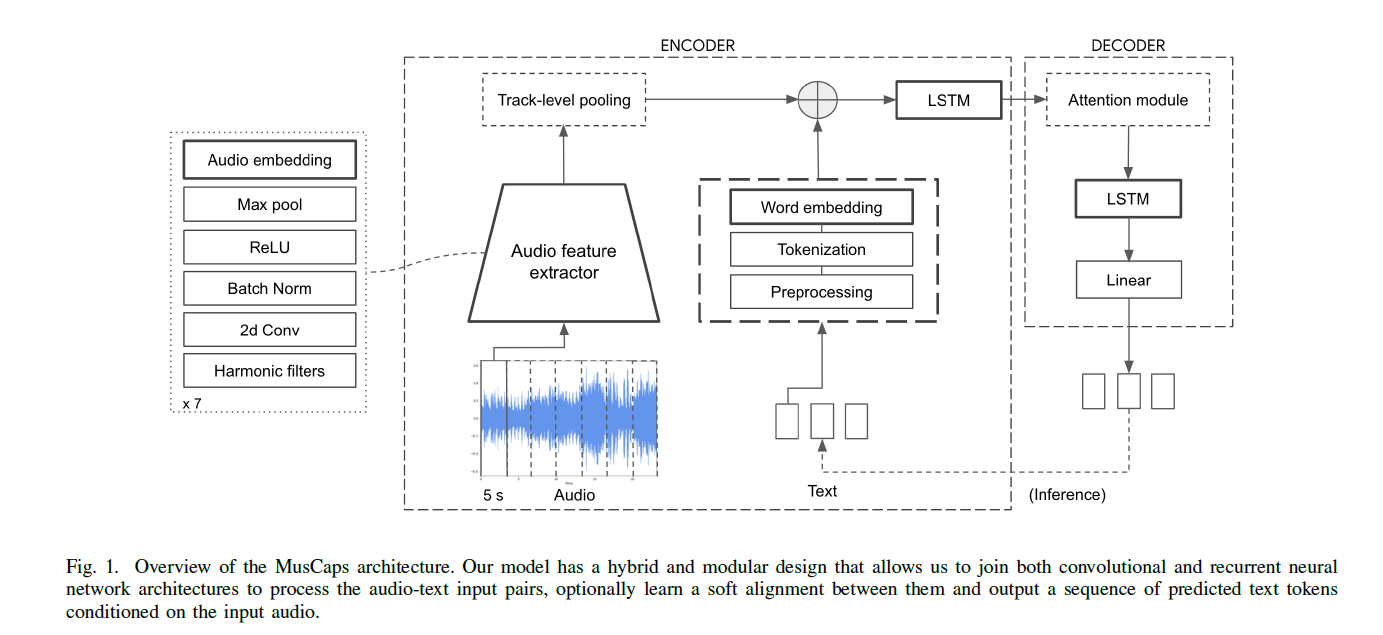

source: 
1. Manco et al., "MusCaps: Generating Captions for Music Audio" (https://arxiv.org/abs/2104.11984)

## Training configuration

The training configuration is shown below, note following were used:

1. Early fusion of audio and text modalities, where audio features and text embeddings are concatenated prior to entering the encoder LSTM.
2. Used a pretrained HarmonicCNN model by Minz Won as the audio feature. extractor, and kept its weights frozen during training. (https://github.com/minzwon/sota-music-tagging-models).
3. Used greedy decoding with a max caption length of 22 words.

Moreover, we used the same optimizer and training regime as the original paper, which used a batch size of 16, an adam optimizer, a learning rate scheduler that linearly reduces the learning rate from the initial value $10^{-4}$, and an early stopping mechanism with a patience of 10.

    model_config:
      model_name: cnn_attention_lstm
      fusion: early
      loss: cross_entropy
      finetune: false
      pool_type: avg
      feature_extractor_type: hcnn
      pretrained_version: mtt
      feature_extractor_path: ${env.data_root}/audio_encoders/${model_config.pretrained_version}_${model_config.feature_extractor_type}.pth
      word_embed_dim: 300
      hidden_dim_encoder: 256
      vocab_size: 0
      attention_dim: 256
      attention_type: mlp
      attention_dropout: 0.25
      dropout_decoder: 0.25
      hidden_dim_decoder: 256
      inference_type: greedy
      beam_size: 2
      max_caption_len: 22

The MusCap model is trained by first importing the following:

1. All audiofiles in npy format to the directory `muscaps\data\datasets\audiocaption\audio`.
2. Three json files, `dataset_train.json`, `dataset_val.json`, `dataset_test.json`, to the directory `data\datasets\audiocaption`. They need to be in the form:


```
[{"track_id": "Track", 
  "caption": 
  {"raw": "This is a caption", 
  "tokens": ["this", "is", "a", "whines"]}}
  ]
```

All These files are available here: https://drive.google.com/drive/folders/1w_6pxiLN5__4Cty1O_BAGmIM_9Eh-LEt.

Once this process is done, training is initiated by running the code below:





In [ ]:
# !python train.py attention --feature_extractor hcnn --pretrained_model mtt --device_num 0

## MusCaps Code

The following briefly summarizes the components of the MusCaps library.

### Utilities

This section contains the utility classes and functions which are used during model creation and training. It contains the following:

1. **Logger.py**: 

  Contains the logger class, which is used for logging the training progress, length of training an epoch (`epoch_time`), and model checkpoints.
2. **Text_decoder.py**: 

  Contains the methods for generating an audio caption during decoding/inference time. As expected from a seq2seq language model implementation, it contains codes for greedy decoding  and beam search. The former is used in this notebook.

  Greedy decoding starts with a sentence start token `<sos>`,  then the token/word with the maximum softmax probability is chosen at each run until either an end of sentence token is reached `<eos>` or it reaches the maximum caption length (22 in this case).
3. **vocab.py**:  

  This section contains the codes needed to create the vocabulary class. Note that in typical NLP deep learning projects, words are represented as indices from a vocabulary, hence there is a need to create conversion dictionaries which allow for the easy convertion of word index to word and vice-versa. Hence the vocabulary class contains the following:
  - word frequency counter
  - word to index dictionary
  - index to word list
4. **Utils.py**: This contains the remaining utilities.

In [ ]:
#==========#
# Logger.py
#==========#

# import os
# import torch
# import time
# from datetime import datetime
# from omegaconf import OmegaConf

# from muscaps.utils.utils import save_json


# def get_epoch_time():
#     return int((datetime.now() - datetime(1970, 1, 1)).total_seconds())


# class Logger:
#     def __init__(self, config):
#         self.config = config
#         if self.config.training.experiment_id is None:
#             self.experiment_id = self.get_timestamp()
#             OmegaConf.update(self.config, "training.experiment_id",
#                              self.experiment_id)
#         else:
#             self.experiment_id = self.config.training.experiment_id
#         self.experiment_dir = os.path.join(self.config.env.experiments_dir,
#                                            self.experiment_id)
#         self.vocab_path = os.path.join(self.experiment_dir, 'vocab.json')

#         self.checkpoint_path = os.path.join(
#             self.experiment_dir, 'checkpoint.pth.tar')

#         self.init_training_log()

#     def init_training_log(self):
#         self.log_filename = os.path.join(
#             self.experiment_dir, "train_log.tsv")
#         if not os.path.exists(self.experiment_dir):
#             os.makedirs(self.experiment_dir)
#             log_file = open(self.log_filename, 'a')
#             log_file.write(
#                 'Epoch\ttrain_loss\tval_loss\tepoch_time\tlearing_rate\ttime_stamp\n'
#             )
#             log_file.close()

#             # Save json with experiment settings
#             OmegaConf.save(self.config,
#                            os.path.join(self.experiment_dir, 'config.yaml'))

#     def get_timestamp(self):
#         return str(time.strftime('%Y-%m-%d-%H_%M_%S', time.gmtime()))

#     def write(self, text):
#         print(text)

#     def save_vocab(self, token_freq):
#         save_json(self.vocab_path, token_freq)

#     def update_training_log(self, epoch, train_loss, val_loss, epoch_time,
#                             learning_rate):
#         time_stamp = str(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime()))
#         self.write(
#             'Epoch %d, train loss %g, val loss %g, epoch-time %gs, lr %g, time-stamp %s'
#             %
#             (epoch, train_loss, val_loss, epoch_time, learning_rate, time_stamp))

#         log_file = open(self.log_filename, 'a')
#         log_file.write('%d\t%g\t%g\t%gs\t%g\t%s\n' %
#                        (epoch, train_loss, val_loss, epoch_time, learning_rate,
#                         time_stamp))
#         log_file.close()

#     def save_checkpoint(self, state, is_best=False):
#         torch.save(state, self.checkpoint_path)
#         if is_best:
#             self.write("Saving best model so far")
#             best_model_path = os.path.join(self.experiment_dir,
#                                            'best_model.pth.tar')
#             torch.save(state, best_model_path)


In [ ]:
#================#
# text_decoder.py
#================#

# import torch


# class TextDecoder():
#     def __init__(self, vocab, config):
#         self._vocab = vocab
#         self._vocab_size = vocab.get_size()
#         self._config = config.model_config
#         self._device = torch.device(config.training.device)
#         self.max_steps = self._config.max_caption_len

#     def decode_caption(self, caption):
#         decoded = [self._vocab.idx2word[i] for i in caption]
#         decoded = ' '.join(decoded)
#         return decoded


# class GreedyDecoder(TextDecoder):
#     def __init__(self, vocab, config):
#         super().__init__(vocab, config)

#     def reset(self):
#         pass

#     def decode(self, model, audio, audio_len):
#         # Tensor to store all with previous words at each step; <sos> at t=0
#         predicted_caption = torch.LongTensor(
#             [self._vocab.get_id('<sos>')]).to(self._device)

#         for t in range(self.max_steps):
#             cap_lens = torch.Tensor(
#                 [len(predicted_caption)]).int().to(self._device)
#             out = model(audio, audio_len, predicted_caption.unsqueeze(0),
#                         cap_lens)
#             prediction = torch.log_softmax(out, dim=2)
#             prediction = torch.argmax(prediction, dim=2)
#             prediction = prediction[:, -1]
#             predicted_caption = torch.cat([predicted_caption, prediction])
#             if prediction == self._vocab.word2idx['<eos>']:
#                 break
#         return predicted_caption


# class BeamSearchDecoder(TextDecoder):
#     """ Adapted from https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/blob/master/eval.py"""

#     def __init__(self, vocab, config):
#         super().__init__(vocab, config)
#         self.reset()

#     def reset(self):
#         self._beam_size = self._config.beam_size

#         self._complete_seqs = []
#         self._complete_seqs_scores = []
#         self.k_prev_words = torch.LongTensor(
#             [[self._vocab.get_id('<sos>')]] * self._beam_size).to(self._device)
#         self.seqs = self.k_prev_words.to(self._device)
#         self.top_k_scores = torch.zeros(self._beam_size, 1).to(self._device)

#     def init_batch(self, audio, audio_len):
#         cap_lens = torch.Tensor(
#             [self.seqs.size(1)] * self._beam_size).int().to(self._device)
#         audio = torch.cat(self._beam_size * [audio], dim=0)
#         audio_len = torch.cat(self._beam_size * [audio_len], dim=0)

#         return cap_lens, audio, audio_len

#     def add_next_word(self, prev_word_inds, next_word_inds):
#         seqs = torch.cat([self.seqs[prev_word_inds],
#                           next_word_inds.unsqueeze(1)], dim=1)
#         return seqs

#     def decode(self, model, audio_in, audio_len_in):
#         self.reset()
#         cap_lens, audio, audio_len = self.init_batch(audio_in, audio_len_in)

#         for t in range(self.max_steps):
#             scores = model(audio, audio_len, self.seqs, cap_lens)
#             scores = torch.log_softmax(scores, dim=2)[:, -1, :]

#             scores = self.top_k_scores.expand_as(
#                 scores) + scores

#             if t == 0:
#                 self.top_k_scores, self.top_k_words = scores[0].topk(
#                     self._beam_size, 0, True, True)
#             else:
#                 self.top_k_scores, self.top_k_words = scores.view(
#                     -1).topk(self._beam_size, 0, True, True)

#             prev_word_inds = self.top_k_words // self._vocab_size
#             next_word_inds = self.top_k_words % self._vocab_size

#             self.seqs = self.add_next_word(prev_word_inds, next_word_inds)

#             incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
#                                next_word != self._vocab.word2idx['<eos>']]
#             complete_inds = list(
#                 set(range(len(next_word_inds))) - set(incomplete_inds))

#             if len(complete_inds) > 0:
#                 self._complete_seqs.extend(
#                     self.seqs[complete_inds].tolist())
#                 self._complete_seqs_scores.extend(
#                     self.top_k_scores[complete_inds])
#             self._beam_size -= len(complete_inds)

#             if self._beam_size == 0:
#                 break
#             self.seqs = self.seqs[incomplete_inds]
#             cap_lens, audio, audio_len = self.init_batch(
#                 audio_in, audio_len_in)
#             self.top_k_scores = self.top_k_scores[incomplete_inds].unsqueeze(1)
#             self.top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(
#                 1)

#             t += 1

#         if len(self._complete_seqs_scores) > 0:
#             i = self._complete_seqs_scores.index(
#                 max(self._complete_seqs_scores))
#             seq = self._complete_seqs[i]
#         else:
#             seq = []

#         return seq

In [ ]:
#=========#
# Vocab.py
#=========#

# """Adapted from https://github.com/facebookresearch/mmf/blob/master/mmf/utils/vocab.py"""

# import torch
# import os
# from torchtext import vocab
# from collections import Counter


# from muscaps.utils.utils import get_root_dir


# class Vocabulary():
#     """ Vocabulary class to covert words and numerical indices.
#     Attributes:
#         token_freq (Counter): frequencies of tokens in the data used to build the Vocab.
#         word2idx (defaultdict): mapping of token strings to numerical identifiers.
#         idx2word (list): string tokens indexed by their numerical identifiers.
#     """

#     def __init__(self,
#                  tokens=None,
#                  token_freq=None,
#                  min_count=2,
#                  pretrained_emb="glove.6B.300d"):
#         """
#         Args:
#             - tokens: list of string tokens with the input text to create the Vocab from.
#             - min_count: threshold token occurrence below which the token is not included in the dictionary
#             - pretrained_emb:
#         """
#         self.PAD_TOKEN = "<pad>"
#         self.UNK_TOKEN = "<unk>"
#         self.SOS_TOKEN = "<sos>"
#         self.EOS_TOKEN = "<eos>"

#         self.min_count = min_count
#         self.pretrained_emb = pretrained_emb

#         if token_freq is None:
#             self.token_freq = Counter(
#                 [i for token_sublist in tokens for i in token_sublist])
#         else:
#             self.token_freq = token_freq

#         self.token_list = []
#         for token in self.token_freq:
#             if self.token_freq[token] >= min_count:
#                 self.token_list.append(token)

#         extras = [
#             self.PAD_TOKEN, self.UNK_TOKEN, self.SOS_TOKEN, self.EOS_TOKEN
#         ]
#         self.idx2word = extras + self.token_list
#         self._build_vocab()
#         self._load_vectors(vector_cache=os.path.join(get_root_dir(), "data"))

#     def _build_vocab(self):
#         self.word2idx = {v: k for k, v in enumerate(self.idx2word)}

#         self.size = self.get_size()

#         self.UNK_INDEX = (self.word2idx[self.UNK_TOKEN]
#                           if self.UNK_TOKEN in self.word2idx else None)

#         self.PAD_INDEX = (self.word2idx[self.PAD_TOKEN]
#                           if self.PAD_TOKEN in self.word2idx else None)

#     def _load_vectors(self, vector_cache):
#         if self.pretrained_emb not in vocab.pretrained_aliases:
#             error = "Unknown embedding type: %s" % self.pretrained_emb, "error"
#             raise RuntimeError(error)

#         if os.path.exists(vector_cache):
#             embedding = vocab.pretrained_aliases[self.pretrained_emb](
#                 cache=vector_cache)
#         else:
#             embedding = vocab.pretrained_aliases[self.pretrained_emb]()
#         # dim of vectors: V x K (vocab dim x embedding dim)
#         self.vectors = torch.FloatTensor(self.size, embedding.dim)

#         for i in range(4):
#             self.vectors[i] = torch.ones_like(self.vectors[i]) * 0.1 * i

#         for i in range(4, self.size):
#             word = self.idx2word[i]
#             embedding_index = embedding.stoi.get(word, None)

#             if embedding_index is None:
#                 self.vectors[i] = self.vectors[self.UNK_INDEX]
#             else:
#                 self.vectors[i] = embedding.vectors[embedding_index]

#     def get_id(self, token):
#         """Convert a string tokens to its numerical id."""
#         if token in self.word2idx:
#             return self.word2idx[token]
#         else:
#             return self.UNK_INDEX

#     def get_string(self, idx):
#         """Convert a numerical id to its string token."""
#         return self.idx2word[idx]

#     def get_size(self):
#         """Get total number of tokens in the vocabulary."""
#         return len(self.idx2word)

#     def get_embedding(self, word):
#         return self.vectors[self.word2idx[word]]

#     def save(self, path):
#         """Save `self.idx2word` in `path`."""
#         with open(path, "w") as f:
#             f.write("\n".join(self.idx2word))

#     def load(self):
#         """Load vocab txt file from `vocab_file`."""
#         with open(self.vocab_file) as f:
#             lines = f.readlines()
#             lines = [l.strip() for l in lines]
#         return lines

In [ ]:
#=========#
# Utils.py
#=========#

# import os
# import json
# from omegaconf import OmegaConf
# import torch


# def load_conf(path_to_yaml):
#     """ Wrapper for configuration file loading through OmegaConf. """
#     conf = OmegaConf.load(path_to_yaml)
#     if "env" in conf.keys():
#         OmegaConf.update(conf, "env.base_dir", get_root_dir())
#     return conf


# def merge_conf(base_conf_path, dataset_conf_path, model_conf_path):
#     """ Wrapper to merge multiple config files through OmegaConf. """
#     base_conf = load_conf(base_conf_path)
#     dataset_conf = load_conf(dataset_conf_path)
#     model_conf = load_conf(model_conf_path)

#     conf = OmegaConf.merge(
#         base_conf, dataset_conf, model_conf)
#     return conf


# def save_json(output_path, content):
#     with open(output_path, 'w') as outfile:
#         json.dump(content, outfile)


# def get_root_dir():
#     root = os.path.dirname(
#         os.path.abspath(__file__))
#     root = os.path.abspath(
#         os.path.join(root, "../.."))
#     return root


# def masked_softmax(vector: torch.Tensor,
#                    mask: torch.Tensor,
#                    dim: int = -1,
#                    memory_efficient: bool = False,
#                    mask_fill_value: float = -1e32) -> torch.Tensor:
#     """
#     Code from https://github.com/allenai/allennlp.
#     ``torch.nn.functional.softmax(vector)`` does not work if some elements of ``vector`` should be
#     masked.  This performs a softmax on just the non-masked portions of ``vector``.  Passing
#     ``None`` in for the mask is also acceptable; you'll just get a regular softmax.
#     ``vector`` can have an arbitrary number of dimensions; the only requirement is that ``mask`` is
#     broadcastable to ``vector's`` shape.  If ``mask`` has fewer dimensions than ``vector``, we will
#     unsqueeze on dimension 1 until they match.  If you need a different unsqueezing of your mask,
#     do it yourself before passing the mask into this function.
#     If ``memory_efficient`` is set to true, we will simply use a very large negative number for those
#     masked positions so that the probabilities of those positions would be approximately 0.
#     This is not accurate in math, but works for most cases and consumes less memory.
#     In the case that the input vector is completely masked and ``memory_efficient`` is false, this function
#     returns an array of ``0.0``. This behavior may cause ``NaN`` if this is used as the last layer of
#     a model that uses categorical cross-entropy loss. Instead, if ``memory_efficient`` is true, this function
#     will treat every element as equal, and do softmax over equal numbers.
#     """
#     if mask is None:
#         result = torch.nn.functional.softmax(
#             vector, dim=dim)
#     else:
#         mask = mask.float()
#         while mask.dim() < vector.dim():
#             mask = mask.unsqueeze(1)
#         if not memory_efficient:
#             # To limit numerical errors from large vector elements outside the mask, we zero these out.
#             result = torch.nn.functional.softmax(
#                 vector * mask, dim=dim)
#             result = result * mask
#             result = result / \
#                 (result.sum(dim=dim, keepdim=True) + 1e-13)
#         else:
#             masked_vector = vector.masked_fill((1 - mask).byte(),
#                                                mask_fill_value)
#             result = torch.nn.functional.softmax(
#                 masked_vector, dim=dim)
#     return result

### Dataset Classes

This section includes the classes that create the model database from the audio files in npy format and the json containing the captions per audio file. Note that the `audiocaption` class also generates a vocabulary from the dataset.

1. base_dataset.py
2. audiocaption.py

In [ ]:
#================#
# base_dataset.py
#================#

# import torch
# from torch.utils.data.dataset import Dataset


# class BaseDataset(Dataset):
#     def __init__(self, config, dataset_type, dataset_name):
#         """Base class for a dataset.
#         Args:
#         - config: dict object with dataset config
#         - dataset_type: "train", "test" or "val"
#         - dataset_name: string of the dataset name 
#         """
#         super().__init__()
#         if config is None:
#             config = {}
#         self.config = config
#         self._dataset_name = dataset_name
#         self._dataset_type = dataset_type
#         self._data_dir = self.config.data_dir

#     def __len__(self):
#         raise NotImplementedError

#     def __getitem__(self, idx):
#         """
#         __getitem__ of a torch dataset.
#         Args:
#             idx (int): Index of the sample to be loaded.
#         """

#         raise NotImplementedError


# def custom_collate_fn(data):
#     """ Custom collate function for data loader to create mini-batch tensors of the same shape. 
#     Args:
#     data: list of tuple (audio, caption). 
#         - audio: torch tensor of shape (?); variable length.
#         - caption: torch tensor of shape (?); variable length.
#     Returns:
#         padded_audio: torch tensor of shape (batch_size, padded_audio_length).
#         padded_captions: torch tensor of shape (batch_size, padded_cap_length).
#     """

#     data.sort(key=lambda x: len(x[1]), reverse=True)
#     audio_tracks, captions = zip(*data)

#     audio_lengths = [len(audio) for audio in audio_tracks]
#     padded_audio = torch.zeros(
#         len(audio_tracks), max(audio_lengths)).float()

#     cap_lengths = [len(cap) for cap in captions]
#     padded_captions = torch.zeros(len(captions), max(cap_lengths)).long()

#     for i, cap in enumerate(captions):
#         caption_end = cap_lengths[i]
#         padded_captions[i, :caption_end] = cap

#         audio_end = audio_lengths[i]
#         padded_audio[i, :audio_end] = audio_tracks[i]

#     audio_lengths = torch.Tensor(audio_lengths).long()

#     return padded_audio, audio_lengths, padded_captions, cap_lengths


In [ ]:
#================#
# audiocaption.py
#================#

# import os
# import json
# import numpy as np
# import torch

# from muscaps.utils.vocab import Vocabulary
# from muscaps.datasets.base_dataset import BaseDataset


# class AudioCaptionDataset(BaseDataset):
#     def __init__(self, config, dataset_type="train"):
#         super().__init__(config, dataset_type, dataset_name="audiocaption")

#         self.dataset_json = os.path.join(
#             self._data_dir, "dataset_{}.json".format(self._dataset_type))
#         self._load()

#     def _load(self):
#         self.sr = self.config.audio.sr

#         with open(self.dataset_json) as f:
#             self.samples = json.load(f)
#             self._build_vocab()

#             self.captions = [[self.vocab.SOS_TOKEN] + i["caption"]['tokens'] +
#                              [self.vocab.EOS_TOKEN] for i in self.samples]

#             self.audio_dir = os.path.join(self._data_dir, "audio")
#             self.audio_paths = [os.path.join(
#                 self.audio_dir, i['track_id']+".npy") for i in self.samples]

#     def _build_vocab(self):
#         """ Build vocab based on captions in the training set"""
#         if self._dataset_type == "train":
#             self.vocab = Vocabulary(
#                 [i["caption"]['tokens'] for i in self.samples])
#         else:
#             training_set = os.path.join(self._data_dir, "dataset_train.json")
#             with open(training_set) as f:
#                 samples = json.load(f)
#                 training_captions = [i["caption"]['tokens'] for i in samples]
#             self.vocab = Vocabulary(training_captions)

#     def get_caption(self, idx):
#         """Get caption and convert list of strings to tensor of word indices"""
#         tokenized_caption = self.captions[idx]
#         token_idx = torch.ShortTensor([
#             self.vocab.word2idx.get(token, self.vocab.UNK_INDEX)
#             for token in tokenized_caption
#         ])
#         return token_idx

#     def get_audio(self, idx):
#         audio = np.load(self.audio_paths[idx]).astype('float32')
#         audio = torch.Tensor(audio)
#         return audio

#     def __getitem__(self, idx):
#         """Return one data pair (audio, caption)."""
#         audio = self.get_audio(idx)
#         token_idx = self.get_caption(idx)
#         return audio, token_idx

#     def __len__(self):
#         return len(self.samples)

#     @classmethod
#     def config_path(cls):
#         return "configs/datasets/dataset.yaml"

### Modules Classes

This section contains the modules within the model structure. It contains the following:

#### Audio Feature extraction
1. Conv_layers.py - Contains the classes for the convolutional layers needed to extract music features from the audio.
2. audio_feature_extractors.py - Contains the CNN models used to extract audio features. We use a version of the HarmonicCNN model pretrained by Minz Won (https://github.com/minzwon/sota-music-tagging-models) as the audio feature extractor model.

#### Encoder
1. Encoder.py - Contains the encoder model class. It contains three main sections:
- Audio feature extractor: Code for the actual feature extraction procedure using HarmonicCNN.
- Word Embeddings: Downloads GLOVE embeddings, then converts text into them. 
- LSTMEncoder: The actual encoder LSTM.

#### Decoder
1. Decoder.py - Contains the decoder LSTM.

#### Attention Component
1. Attention.py - Contains the attention component of the model.

In [ ]:
#==============#
# conv_layers.py
#==============#

# """ Code from https://github.com/minzwon/sota-music-tagging-models/ 
# MIT License
# Copyright (c) 2020 Music Technology Group, Universitat Pompeu Fabra. Code developed by Minz Won.
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
# """

# import numpy as np
# import librosa
# import torch
# import torch.nn as nn


# class Conv_1d(nn.Module):
#     def __init__(self,
#                  input_channels,
#                  output_channels,
#                  shape=3,
#                  stride=1,
#                  pooling=2):
#         super(Conv_1d, self).__init__()
#         self.conv = nn.Conv1d(input_channels,
#                               output_channels,
#                               shape,
#                               stride=stride,
#                               padding=shape // 2)
#         self.bn = nn.BatchNorm1d(output_channels)
#         self.relu = nn.ReLU()
#         self.mp = nn.MaxPool1d(pooling)

#     def forward(self, x):
#         out = self.mp(self.relu(self.bn(self.conv(x))))
#         return out


# class Conv_2d(nn.Module):
#     def __init__(self,
#                  input_channels,
#                  output_channels,
#                  shape=3,
#                  stride=1,
#                  pooling=2):
#         super(Conv_2d, self).__init__()
#         self.conv = nn.Conv2d(input_channels,
#                               output_channels,
#                               shape,
#                               stride=stride,
#                               padding=shape // 2)
#         self.bn = nn.BatchNorm2d(output_channels)
#         self.relu = nn.ReLU()
#         self.mp = nn.MaxPool2d(pooling)

#     def forward(self, x):
#         out = self.mp(self.relu(self.bn(self.conv(x))))
#         return out


# class Conv_V(nn.Module):
#     # vertical convolution
#     def __init__(self, input_channels, output_channels, filter_shape):
#         super(Conv_V, self).__init__()
#         self.conv = nn.Conv2d(input_channels,
#                               output_channels,
#                               filter_shape,
#                               padding=(0, filter_shape[1] // 2))
#         self.bn = nn.BatchNorm2d(output_channels)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.bn(self.conv(x)))
#         freq = x.size(2)
#         out = nn.MaxPool2d((freq, 1), stride=(freq, 1))(x)
#         out = out.squeeze(2)
#         return out


# class Conv_H(nn.Module):
#     # horizontal convolution
#     def __init__(self, input_channels, output_channels, filter_length):
#         super(Conv_H, self).__init__()
#         self.conv = nn.Conv1d(input_channels,
#                               output_channels,
#                               filter_length,
#                               padding=filter_length // 2)
#         self.bn = nn.BatchNorm1d(output_channels)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         freq = x.size(2)
#         out = nn.AvgPool2d((freq, 1), stride=(freq, 1))(x)
#         out = out.squeeze(2)
#         out = self.relu(self.bn(self.conv(out)))
#         return out


# class Res_2d_mp(nn.Module):
#     def __init__(self, input_channels, output_channels, pooling=2):
#         super(Res_2d_mp, self).__init__()
#         self.conv_1 = nn.Conv2d(input_channels, output_channels, 3, padding=1)
#         self.bn_1 = nn.BatchNorm2d(output_channels)
#         self.conv_2 = nn.Conv2d(output_channels, output_channels, 3, padding=1)
#         self.bn_2 = nn.BatchNorm2d(output_channels)
#         self.relu = nn.ReLU()
#         self.mp = nn.MaxPool2d(pooling)

#     def forward(self, x):
#         out = self.bn_2(self.conv_2(self.relu(self.bn_1(self.conv_1(x)))))
#         out = x + out
#         out = self.mp(self.relu(out))
#         return out


# # Modules for harmonic filters
# def hz_to_midi(hz):
#     return 12 * (torch.log2(hz) - np.log2(440.0)) + 69


# def midi_to_hz(midi):
#     return 440.0 * (2.0**((midi - 69.0) / 12.0))


# def note_to_midi(note):
#     return librosa.core.note_to_midi(note)


# def hz_to_note(hz):
#     return librosa.core.hz_to_note(hz)


# def initialize_filterbank(sample_rate, n_harmonic, semitone_scale):
#     # MIDI
#     # lowest note
#     low_midi = note_to_midi('C1')

#     # highest note
#     high_note = hz_to_note(sample_rate / (2 * n_harmonic))
#     high_midi = note_to_midi(high_note)

#     # number of scales
#     level = (high_midi - low_midi) * semitone_scale
#     midi = np.linspace(low_midi, high_midi, level + 1)
#     hz = midi_to_hz(midi[:-1])

#     # stack harmonics
#     harmonic_hz = []
#     for i in range(n_harmonic):
#         harmonic_hz = np.concatenate((harmonic_hz, hz * (i + 1)))

#    return harmonic_hz, level

In [ ]:
#============================#
# audio_feature_extractors.py
#============================#

# """ Code from https://github.com/minzwon/sota-music-tagging-models/ 
# MIT License
# Copyright (c) 2020 Music Technology Group, Universitat Pompeu Fabra. Code developed by Minz Won.
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
# """

# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchaudio

# from muscaps.modules.conv_layers import Conv_1d, Conv_2d, Res_2d_mp, initialize_filterbank, Conv_V, Conv_H


# class HarmonicSTFT(nn.Module):
#     def __init__(self,
#                  sample_rate=16000,
#                  n_fft=513,
#                  win_length=None,
#                  hop_length=None,
#                  pad=0,
#                  power=2,
#                  normalized=False,
#                  n_harmonic=6,
#                  semitone_scale=2,
#                  bw_Q=1.0,
#                  learn_bw=None):
#         super(HarmonicSTFT, self).__init__()

#         # Parameters
#         self.sample_rate = sample_rate
#         self.n_harmonic = n_harmonic
#         self.bw_alpha = 0.1079
#         self.bw_beta = 24.7

#         # Spectrogram
#         self.spec = torchaudio.transforms.Spectrogram(
#             n_fft=n_fft,
#             win_length=win_length,
#             hop_length=None,
#             pad=0,
#             window_fn=torch.hann_window,
#             power=power,
#             normalized=normalized,
#             wkwargs=None)
#         self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

#         # Initialize the filterbank. Equally spaced in MIDI scale.
#         harmonic_hz, self.level = initialize_filterbank(
#             sample_rate, n_harmonic, semitone_scale)

#         # Center frequncies to tensor
#         self.f0 = torch.tensor(harmonic_hz.astype('float32'))

#         # Bandwidth parameters
#         if learn_bw == 'only_Q':
#             self.bw_Q = nn.Parameter(
#                 torch.tensor(np.array([bw_Q]).astype('float32')))
#         elif learn_bw == 'fix':
#             self.bw_Q = torch.tensor(np.array([bw_Q]).astype('float32'))

#     def get_harmonic_fb(self):
#         # bandwidth
#         bw = (self.bw_alpha * self.f0 + self.bw_beta) / self.bw_Q
#         bw = bw.unsqueeze(0)  # (1, n_band)
#         f0 = self.f0.unsqueeze(0)  # (1, n_band)
#         fft_bins = self.fft_bins.unsqueeze(1)  # (n_bins, 1)

#         up_slope = torch.matmul(fft_bins, (2 / bw)) + 1 - (2 * f0 / bw)
#         down_slope = torch.matmul(fft_bins, (-2 / bw)) + 1 + (2 * f0 / bw)
#         fb = torch.max(self.zero, torch.min(down_slope, up_slope))
#         return fb

#     def to_device(self, device, n_bins):
#         self.f0 = self.f0.to(device)
#         self.bw_Q = self.bw_Q.to(device)
#         # fft bins
#         self.fft_bins = torch.linspace(0, self.sample_rate // 2, n_bins)
#         self.fft_bins = self.fft_bins.to(device)
#         self.zero = torch.zeros(1)
#         self.zero = self.zero.to(device)

#     def forward(self, waveform):
#         # stft
#         spectrogram = self.spec(waveform)

#         # to device
#         self.to_device(waveform.device, spectrogram.size(1))

#         # triangle filter
#         harmonic_fb = self.get_harmonic_fb()
#         harmonic_spec = torch.matmul(spectrogram.transpose(1, 2),
#                                      harmonic_fb).transpose(1, 2)

#         # (batch, channel, length) -> (batch, harmonic, f0, length)
#         b, c, l = harmonic_spec.size()
#         harmonic_spec = harmonic_spec.view(b, self.n_harmonic, self.level, l)

#         # amplitude to db
#         harmonic_spec = self.amplitude_to_db(harmonic_spec)
#         return harmonic_spec


# class HarmonicCNN(nn.Module):
#     '''
#     Won et al. 2020
#     Data-driven harmonic filters for audio representation learning.
#     Trainable harmonic band-pass filters, short-chunk CNN.
#     '''

#     def __init__(self,
#                  n_channels=128,
#                  sample_rate=16000,
#                  n_fft=512,
#                  f_min=0.0,
#                  f_max=8000.0,
#                  n_mels=128,
#                  n_class=50,
#                  n_harmonic=6,
#                  semitone_scale=2,
#                  learn_bw='only_Q'):
#         super(HarmonicCNN, self).__init__()

#         # Harmonic STFT
#         self.hstft = HarmonicSTFT(sample_rate=sample_rate,
#                                   n_fft=n_fft,
#                                   n_harmonic=n_harmonic,
#                                   semitone_scale=semitone_scale,
#                                   learn_bw=learn_bw)
#         self.hstft_bn = nn.BatchNorm2d(n_harmonic)

#         # CNN
#         self.layer1 = Conv_2d(n_harmonic, n_channels, pooling=2)
#         self.layer2 = Res_2d_mp(n_channels, n_channels, pooling=2)
#         self.layer3 = Res_2d_mp(n_channels, n_channels, pooling=2)
#         self.layer4 = Res_2d_mp(n_channels, n_channels, pooling=2)
#         self.layer5 = Conv_2d(n_channels, n_channels * 2, pooling=2)
#         self.layer6 = Res_2d_mp(n_channels * 2, n_channels * 2, pooling=(2, 3))
#         self.layer7 = Res_2d_mp(n_channels * 2, n_channels * 2, pooling=(2, 3))

#         # Dense
#         self.dense1 = nn.Linear(n_channels * 2, n_channels * 2)
#         self.bn = nn.BatchNorm1d(n_channels * 2)
#         self.dense2 = nn.Linear(n_channels * 2, n_class)
#         self.dropout = nn.Dropout(0.5)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # Spectrogram
#         x = self.hstft_bn(self.hstft(x))

#         # CNN
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = self.layer6(x)
#         x = self.layer7(x)
#         x = x.squeeze(2)

#         # Global Max Pooling
#         if x.size(-1) != 1:
#             x = nn.MaxPool1d(x.size(-1))(x)
#         x = x.squeeze(2)

#         return x


# class Musicnn(nn.Module):
#     '''
#     Pons et al. 2017
#     End-to-end learning for music audio tagging at scale.
#     This is the updated implementation of the original paper. Referred to the Musicnn code.
#     https://github.com/jordipons/musicnn
#     '''

#     def __init__(self,
#                  sample_rate=16000,
#                  n_fft=512,
#                  f_min=0.0,
#                  f_max=8000.0,
#                  n_mels=96,
#                  n_class=50,
#                  dataset='msd'):
#         super(Musicnn, self).__init__()

#         # Spectrogram
#         self.spec = torchaudio.transforms.MelSpectrogram(
#             sample_rate=sample_rate,
#             n_fft=n_fft,
#             f_min=f_min,
#             f_max=f_max,
#             n_mels=n_mels)
#         self.to_db = torchaudio.transforms.AmplitudeToDB()
#         self.spec_bn = nn.BatchNorm2d(1)

#         # Pons front-end
#         m1 = Conv_V(1, 204, (int(0.7 * 96), 7))
#         m2 = Conv_V(1, 204, (int(0.4 * 96), 7))
#         m3 = Conv_H(1, 51, 129)
#         m4 = Conv_H(1, 51, 65)
#         m5 = Conv_H(1, 51, 33)
#         self.layers = nn.ModuleList([m1, m2, m3, m4, m5])

#         # Pons back-end
#         backend_channel = 512 if dataset == 'msd' else 64
#         self.layer1 = Conv_1d(561, backend_channel, 7, 1, 1)
#         self.layer2 = Conv_1d(backend_channel, backend_channel, 7, 1, 1)
#         self.layer3 = Conv_1d(backend_channel, backend_channel, 7, 1, 1)

#         # Dense
#         dense_channel = 500 if dataset == 'msd' else 200
#         self.dense1 = nn.Linear((561 + (backend_channel * 3)) * 2,
#                                 dense_channel)
#         self.bn = nn.BatchNorm1d(dense_channel)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.5)
#         self.dense2 = nn.Linear(dense_channel, n_class)

#     def forward(self, x):
#         # Spectrogram
#         x = self.spec(x)
#         x = self.to_db(x)
#         x = x.unsqueeze(1)
#         x = self.spec_bn(x)

#         # Pons front-end
#         out = []
#         for layer in self.layers:
#             out.append(layer(x))
#         out = torch.cat(out, dim=1)

#         length = out.size(2)
#         res1 = self.layer1(out)
#         res2 = self.layer2(res1) + res1
#         res3 = self.layer3(res2) + res2
#         out = torch.cat([out, res1, res2, res3], 1)

#         return out

In [ ]:
#==============#
# Encoder.py
#==============#

# import random
# import torch
# import torch.nn as nn

# from muscaps.modules.audio_feature_extractors import HarmonicCNN, Musicnn


# class AudioEncoder(nn.Module):
#     """ Base class for audio encoders."""

#     def __init__(self, config, device):
#         super().__init__()

#         self.device = device
#         self.config = config
#         self.pool_type = self.config.pool_type

#         self.build()

#     def build(self):
#         raise NotImplementedError


# class CNNEncoder(AudioEncoder):
#     def __init__(self, config, device):
#         super().__init__(config, device)

#     def build(self):
#         self._build_feature_extractor()

#     def _build_feature_extractor(self):
#         self.feature_extractor_type = self.config.feature_extractor_type
#         self.feature_extractor_path = self.config.feature_extractor_path
#         self.pretrained_version = self.config.pretrained_version
#         if self.feature_extractor_type == "hcnn":
#             self.feature_extractor = HarmonicCNN()
#             self.input_length = 5 * 16000
#             self.audio_feature_dim = 256
#         elif self.feature_extractor_type == "musicnn":
#             self.feature_extractor = Musicnn(
#                 dataset=self.pretrained_version)
#             self.input_length = 3 * 16000
#             self.audio_feature_dim = 2097 if self.pretrained_version == "msd" else 753
#         if self.pretrained_version is not None:
#             state_dict = torch.load(self.feature_extractor_path)
#             self.feature_extractor.load_state_dict(
#                 state_dict, strict=False)
#         if self.pool_type == "avg":
#             self.pool = nn.AdaptiveAvgPool2d((1, self.audio_feature_dim))

#     def extract_features(self, audio, audio_len):
#         audio_chunks = torch.split(audio, self.input_length, 1)
#         audio_chunks = torch.stack(
#             [i for i in audio_chunks if i.size(1) == self.input_length],
#             dim=0)
#         if self.pretrained_version is None:
#             num_chunks_to_select = 4
#             max_non_zero_len = int(min(audio_len).item(
#             )/(self.input_length)) - num_chunks_to_select
#             random_int_start = random.randint(0, max_non_zero_len)
#             audio_chunks = audio_chunks[random_int_start:
#                                         random_int_start+num_chunks_to_select]

#         num_chunks, batch_size, _ = audio_chunks.size()
#         audio_features = torch.zeros(batch_size, num_chunks,
#                                      self.audio_feature_dim)

#         for i, chunk in enumerate(audio_chunks):
#             if torch.nonzero(chunk).size(1) != 0:
#                 if self.feature_extractor_type == "hcnn":
#                     audio_features[:, i] = self.feature_extractor(chunk)
#                 elif self.feature_extractor_type == "musicnn":
#                     feature = self.feature_extractor(chunk)
#                     feature = nn.MaxPool1d(feature.size(-1))(feature)
#                     feature = feature.squeeze(-1)
#                     audio_features[:, i] = feature
#         audio_features = audio_features.to(self.device)
#         return audio_features

#     def forward(self, x, audio_len):
#         x = self.extract_features(x, audio_len)
#         if self.pool_type == "avg":
#             pooled_x = self.pool(x)
#             pooled_x = pooled_x.squeeze()
#         else:
#             pooled_x = x
#         return pooled_x, x


# class TextEncoder(nn.Module):
#     def __init__(self, vocab):
#         super().__init__()
#         self.vocab = vocab

#         self.build()

#     def build(self):
#         raise NotImplementedError


# class WordEmbeddingEncoder(TextEncoder):
#     def __init__(self, vocab):
#         super().__init__(vocab)

#     def build(self):
#         self._build_word_embedding()

#     def _build_word_embedding(self):
#         glove_weights = self.vocab.vectors
#         self.word_embeddings = nn.Embedding.from_pretrained(
#             glove_weights, padding_idx=self.vocab.PAD_INDEX)
#         self.word_embed_dim = self.word_embeddings.embedding_dim

#     def forward(self, x):
#         word_embeds = self.word_embeddings(x)

#         return word_embeds


# class SentenceEncoder(nn.Module):
#     """ Base class for sentence encoders."""

#     def __init__(self, config, device):
#         super().__init__()
#         self.config = config
#         self.device = device
#         self.word_embed_dim = self.config.word_embed_dim
#         self.hidden_dim = self.config.hidden_dim_encoder
#         self.fusion = self.config.fusion

#         self.build()

#     def build(self):
#         raise NotImplementedError


# class LSTMEncoder(SentenceEncoder):
#     def __init__(self, config, device):
#         super().__init__(config, device)

#     def build(self):
#         self._encode_sentence()

#     def _encode_sentence(self):
#         if self.fusion == "init":
#             self.lstm = nn.LSTM(self.word_embed_dim,
#                                 self.hidden_dim,
#                                 batch_first=True)
#         elif self.fusion == "early":
#             self.lstm = nn.LSTM(self.word_embed_dim + self.hidden_dim,
#                                 self.hidden_dim,
#                                 batch_first=True)
#         elif self.fusion == "late":
#             self.lstm = nn.LSTM(self.word_embed_dim,
#                                 self.hidden_dim,
#                                 batch_first=True)

#     def forward(self, audio_embeds, word_embeds, x_len):
#         audio_embeds = audio_embeds.unsqueeze(1)
#         if len(audio_embeds.size()) == 2:
#             audio_embeds = audio_embeds.unsqueeze(0)

#         batch_size, _, _ = audio_embeds.size()
#         c_init = torch.zeros((1, batch_size, self.hidden_dim)).to(self.device)

#         if self.fusion == "init":
#             lstm_input = word_embeds
#             h_init = audio_embeds
#         elif self.fusion == "early":
#             h_init = torch.zeros(
#                 (1, batch_size, self.hidden_dim)).to(self.device)
#             audio_embeds = torch.cat(word_embeds.size(1) * [audio_embeds],
#                                      dim=1)
#             lstm_input = torch.cat((audio_embeds, word_embeds), dim=2)
#         elif self.fusion == "late":
#             audio_embeds = torch.cat(word_embeds.size(1) * [audio_embeds],
#                                      dim=1)
#             lstm_input = word_embeds
#             h_init = torch.zeros(
#                 (1, batch_size, self.hidden_dim)).to(self.device)
#         x_len = torch.as_tensor(x_len, dtype=torch.int64, device="cpu")
#         lstm_input = nn.utils.rnn.pack_padded_sequence(lstm_input,
#                                                        x_len,
#                                                        enforce_sorted=False,
#                                                        batch_first=True)
#         lstm_out, (hidden_state, _) = self.lstm(lstm_input, (h_init, c_init))
#         lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out,
#                                                              batch_first=True)
#         if self.fusion == "late":
#             lstm_out = torch.cat((lstm_out, audio_embeds), dim=2)

#         return lstm_out

In [ ]:
#=============#
# Decoders.py
#=============#

# import torch.nn as nn
# from torch.nn.utils import weight_norm


# class Decoder(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.config = config
#         self.n_classes = self.config.vocab_size
#         self.dropout_p = self.config.dropout_decoder

#         self.build()

#     def build(self):
#         raise NotImplementedError


# class LSTMDecoder(Decoder):
#     def __init__(self, config, input_dim, hidden_dim):
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         super().__init__(config)

#     def build(self):
#         self.lstm_cell = nn.LSTMCell(input_size=self.input_dim,
#                                      hidden_size=self.hidden_dim)
#         self.dense = weight_norm(nn.Linear(self.hidden_dim, self.n_classes))
#         self.dropout = nn.Dropout(p=self.dropout_p)
#         # self.init_weights()

#     def init_weights(self, layer=None):
#         if layer is None:
#             self.dense.bias.data.fill_(0)
#             self.dense.weight.data.uniform_(-0.1, 0.1)

#     def forward(self, x, h, c):
#         hidden_state, cell_state = self.lstm_cell(x, (h, c))
#         out = self.dense(self.dropout(hidden_state))
#         return out, hidden_state, cell_state

In [ ]:
#=============#
# Attention.py
#=============#

# import torch.nn as nn

# from muscaps.utils.utils import masked_softmax


# class Attention(nn.Module):
#     def __init__(self, config, audio_feature_dim):
#         super().__init__()
#         self.audio_feature_dim = audio_feature_dim
#         self.attention_dim = config.attention_dim
#         self.hidden_dim = config.hidden_dim_encoder
#         self.attention_type = config.attention_type

#         self.audio_projection = nn.Linear(self.audio_feature_dim,
#                                           self.attention_dim)
#         self.query_projection = nn.Linear(self.hidden_dim, self.attention_dim)
#         self.dropout = nn.Dropout(config.attention_dropout)
#         self.linear = nn.Linear(self.attention_dim, 1)

#         self.tanh = nn.Tanh()
#         self.softmax = nn.Softmax()

#     def forward(self, hidden_state, audio_features, audio_feature_mask):
#         """ 
#         Args:
#             - hidden_state: Tensor (batch_size, hidden_dim_encoder)
#             - audio_features: Tensor of shape (batch_size, num_chunks, audio_feature_dim)
#             - audio_feature_mask: Dict[str, torch.Tensor], with Tensor of shape (batch_size, num_chunks, audio_feature_dim)
#         """
#         projected_features = self.audio_projection(audio_features)
#         projected_query = self.query_projection(hidden_state)
#         # (batch_size, num_chunks, attention_dim)
#         projected_query = projected_query.unsqueeze(1).repeat(
#             1, projected_features.size(1), 1)

#         if self.attention_type == "mlp":
#             attention_scores = self.linear(
#                 self.tanh(projected_features + projected_query))
#             attention_scores = attention_scores.squeeze(-1)
#         elif self.linear == "dot":
#             joint_repr = projected_features * projected_query
#             joint_repr = self.dropout(joint_repr)
#             attention_scores = self.linear(joint_repr)

#         alpha_weights = masked_softmax(attention_scores,
#                                        audio_feature_mask,
#                                        dim=-1)

#         return alpha_weights

### Model Code

This section consolidates the module classes defined earlier into one singular model class. We use the model with attention.

In [ ]:
#=====================#
# cnn_attention_lstm.py
#=====================#

# import torch
# import torch.nn as nn

# from muscaps.modules.decoders import LSTMDecoder
# from muscaps.modules.attention import Attention
# from muscaps.modules.encoders import CNNEncoder, WordEmbeddingEncoder


# class AttentionModel(nn.Module):
#     def __init__(self, config, vocab, device, teacher_forcing):
#         super().__init__()
#         self.vocab = vocab
#         self.config = config
#         self.teacher_forcing = teacher_forcing
#         self.attention_dim = self.config.attention_dim
#         self.hidden_dim_encoder = self.config.hidden_dim_encoder
#         self.hidden_dim_decoder = self.config.hidden_dim_decoder
#         self.finetune = self.config.finetune

#         self.audio_encoder = CNNEncoder(self.config, device)
#         self.audio_feature_dim = self.audio_encoder.audio_feature_dim
#         self.text_encoder = WordEmbeddingEncoder(self.vocab)
#         self.word_embed_dim = self.text_encoder.word_embed_dim

#         self.audio_linear = nn.Linear(self.audio_encoder.audio_feature_dim,
#                                       self.hidden_dim_encoder)
#         self.batch_norm = nn.BatchNorm1d(self.hidden_dim_encoder)
#         self.relu = nn.ReLU()
#         self.encoder = nn.LSTMCell(self.word_embed_dim +
#                                    2 * self.hidden_dim_encoder, self.hidden_dim_encoder)
#         self.attention = Attention(self.config, self.audio_feature_dim)
#         self.decoder = LSTMDecoder(
#             self.config, self.hidden_dim_decoder + self.audio_feature_dim, self.hidden_dim_decoder)

#         self.log_softmax = nn.LogSoftmax(dim=1)

#     def init_lstm_states(self, features):
#         state = features
#         lstm_states = {
#             "h1": state.clone(),
#             "c1": state.clone(),
#             "h2": state.clone(),
#             "c2": state.clone(),
#         }
#         return lstm_states

#     def forward(self, audio, audio_len, caption=None, states=None):
#         pooled_features, audio_features = self.audio_encoder(audio, audio_len)
#         pooled_audio_embeds = self.audio_linear(pooled_features)
#         if len(pooled_audio_embeds.size()) != 2:
#             pooled_audio_embeds = pooled_audio_embeds.unsqueeze(0)
#         pooled_audio_embeds = self.relu(self.batch_norm(pooled_audio_embeds))

#         word_embeds = self.text_encoder(caption)

#         self.batch_size, seq_len, _ = word_embeds.size()

#         # Create mask for audio features (to be used in softmax later)
#         max_len = audio_features.size(1)
#         audio_len = audio_len // self.audio_encoder.input_length
#         audio_feature_mask = torch.arange(max_len).expand(
#             len(audio_len), max_len) < audio_len.unsqueeze(1)
#         audio_feature_mask = audio_feature_mask.cuda()

#         states = self.init_lstm_states(pooled_audio_embeds)

#         if self.teacher_forcing:
#             seq_len -= 1

#         outputs = torch.zeros(self.batch_size, seq_len, self.vocab.size).cuda()

#         if len(pooled_audio_embeds.size()) == 1:
#             pooled_audio_embeds = pooled_audio_embeds.unsqueeze(0)

#         for t in range(seq_len):
#             # ENCODER
#             word_embed = word_embeds[:, t, :]
#             encoder_lstm_input = torch.cat(
#                 [word_embed, pooled_audio_embeds, states["h2"]], dim=1)
#             states["h1"], states["c1"] = self.encoder(
#                 encoder_lstm_input, (states["h1"], states["c1"]))

#             # ATTENTION
#             attention_weights = self.attention(states["h1"], audio_features,
#                                                audio_feature_mask)
#             attended_features = torch.sum(attention_weights.unsqueeze(-1) *
#                                           audio_features,
#                                           dim=1)

#             # DECODER
#             decoder_input = torch.cat([attended_features, states["h1"]], dim=1)
#             out, states["h2"], states["c2"] = self.decoder(
#                 decoder_input, states["h2"], states["c2"])

#             outputs[:, t, :] = out

#         return outputs

#     @classmethod
#     def config_path(cls):
#         return "configs/models/cnn_attention_lstm.yaml"

### training code

This section contains the codes that define the base training loop.

In [ ]:
#================#
# Base trainer.py
#================#

# from abc import ABC, abstractmethod


# class BaseTrainer:
#     def __init__(self, model, loss, optimizer, batch_size, logger):
#         pass

#     @abstractmethod
#     def load_dataset(self):
#         """Load dataset and dataloader."""

#     @abstractmethod
#     def build_model(self):
#         """Build the model."""

#     @abstractmethod
#     def load_optimizer(self):
#         """Load the optimizer."""

#     @abstractmethod
#     def load_metrics(self):
#         """Load metrics for evaluation."""

#     @abstractmethod
#     def train(self):
#         """Run the training process."""

In [ ]:
#===================#
# muscaps_trainer.py
#===================#

# import os
# import time
# import numpy as np
# from omegaconf import OmegaConf

# import torch
# from torch import nn
# from torch.nn.utils import clip_grad_norm_
# from torch.utils.data import DataLoader
# from torch.optim import Adam, lr_scheduler, Adadelta

# from muscaps.datasets.base_dataset import custom_collate_fn
# from muscaps.datasets.audiocaption import AudioCaptionDataset
# from muscaps.models.cnn_lstm_caption import CNNLSTMCaption
# from muscaps.models.cnn_attention_lstm import AttentionModel
# from muscaps.trainers.base_trainer import BaseTrainer


# class MusCapsTrainer(BaseTrainer):
#     def __init__(self, config, logger):
#         super(BaseTrainer, self).__init__()
#         self.config = config
#         self.logger = logger
#         self.device = torch.device(self.config.training.device)
#         self.patience = self.config.training.patience
#         self.lr = self.config.training.lr

#         self.load_dataset()
#         self.build_model()
#         self.build_loss()
#         self.build_optimizer()

#     def load_dataset(self):
#         self.logger.write("Loading dataset")
#         dataset_name = self.config.dataset_config.dataset_name
#         if dataset_name == "audiocaption":
#             train_dataset = AudioCaptionDataset(self.config.dataset_config)
#             val_dataset = AudioCaptionDataset(
#                 self.config.dataset_config, "val")
#         else:
#             raise ValueError(
#                 "{} dataset is not supported.".format(dataset_name))
#         self.vocab = train_dataset.vocab
#         self.logger.save_vocab(self.vocab.token_freq)
#         OmegaConf.update(self.config, "model_config.vocab_size",
#                          self.vocab.size)
#         self.train_loader = DataLoader(
#             dataset=train_dataset,
#             batch_size=self.config.training.batch_size,
#             shuffle=self.config.training.shuffle,
#             num_workers=self.config.training.num_workers,
#             pin_memory=self.config.training.pin_memory,
#             collate_fn=custom_collate_fn,
#             drop_last=True)
#         self.val_loader = DataLoader(
#             dataset=val_dataset,
#             batch_size=self.config.training.batch_size,
#             shuffle=self.config.training.shuffle,
#             num_workers=self.config.training.num_workers,
#             pin_memory=self.config.training.pin_memory,
#             collate_fn=custom_collate_fn)
#         self.logger.write("Number of training samples: {}".format(
#             train_dataset.__len__()))

#     def build_model(self):
#         self.logger.write("Building model")
#         model_name = self.config.model_config.model_name
#         if model_name == "cnn_lstm_caption":
#             self.model = CNNLSTMCaption(
#                 self.config.model_config, self.vocab, self.device, teacher_forcing=True)
#         elif model_name == "cnn_attention_lstm":
#             self.model = AttentionModel(
#                 self.config.model_config, self.vocab, self.device, teacher_forcing=True)
#         else:
#             raise ValueError("{} model is not supported.".format(model_name))
#         if self.model.audio_encoder.pretrained_version is not None and not self.model.finetune:
#             for param in self.model.audio_encoder.feature_extractor.parameters():
#                 param.requires_grad = False
#         self.model.to(self.device)

#     def count_parameters(self):
#         """ Count trainable parameters in model. """
#         return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

#     def build_loss(self):
#         self.logger.write("Building loss")
#         loss_name = self.config.model_config.loss
#         if loss_name == "cross_entropy":
#             self.loss = nn.CrossEntropyLoss(ignore_index=self.vocab.PAD_INDEX)
#         else:
#             raise ValueError("{} loss is not supported.".format(loss_name))
#         self.loss = self.loss.to(self.device)

#     def build_optimizer(self):
#         self.logger.write("Building optimizer")
#         optimizer_name = self.config.training.optimizer
#         if optimizer_name == "adam":
#             self.optimizer = Adam(self.model.parameters(), lr=self.lr)
#         elif optimizer_name == "adadelta":
#             self.optimizer = Adadelta(self.model.parameters(), lr=self.lr)
#         else:
#             raise ValueError(
#                 "{} optimizer is not supported.".format(optimizer_name))

#     def train(self):
#         if os.path.exists(self.logger.checkpoint_path):
#             self.logger.write("Resumed training experiment with id {}".format(
#                 self.logger.experiment_id))
#             self.load_ckp(self.logger.checkpoint_path)
#         else:
#             self.logger.write("Started training experiment with id {}".format(
#                 self.logger.experiment_id))
#             self.start_epoch = 0

#         # Adaptive learning rate
#         scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer,
#                                                    mode='min',
#                                                    factor=0.5,
#                                                    patience=self.patience,
#                                                    verbose=True)

#         k_patience = 0
#         best_val = np.Inf

#         for epoch in range(self.start_epoch, self.config.training.epochs):
#             epoch_start_time = time.time()

#             train_loss = self.train_epoch(
#                 self.train_loader, self.device, is_training=True)
#             val_loss = self.train_epoch_val(
#                 self.val_loader, self.device, is_training=False)

#             # Decrease the learning rate after not improving in the validation set
#             scheduler.step(val_loss)

#             # check if val loss has been improving during patience period. If not, stop
#             is_val_improving = scheduler.is_better(val_loss, best_val)
#             if not is_val_improving:
#                 k_patience += 1
#             else:
#                 k_patience = 0
#             if k_patience > self.patience * 2:
#                 print("Early Stopping")
#                 break

#             best_val = scheduler.best

#             epoch_time = time.time() - epoch_start_time
#             lr = self.optimizer.param_groups[0]['lr']

#             self.logger.update_training_log(epoch + 1, train_loss, val_loss,
#                                             epoch_time, lr)

#             checkpoint = {
#                 'epoch': epoch + 1,
#                 'state_dict': self.model.state_dict(),
#                 'optimizer': self.optimizer.state_dict()
#             }

#             # save checkpoint in appropriate path (new or best)
#             self.logger.save_checkpoint(state=checkpoint,
#                                         is_best=is_val_improving)

#     def load_ckp(self, checkpoint_path):
#         checkpoint = torch.load(checkpoint_path)
#         self.model.load_state_dict(checkpoint['state_dict'])
#         self.optimizer.load_state_dict(checkpoint['optimizer'])
#         self.start_epoch = checkpoint['epoch']

#     def train_epoch(self, data_loader, device, is_training):
#         out_list = []
#         target_list = []
#         running_loss = 0.0
#         n_batches = 0

#         if is_training:
#             self.model.train()
#             if self.model.audio_encoder.pretrained_version is not None:
#                 for module in self.model.audio_encoder.feature_extractor.modules():
#                     if isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.BatchNorm1d):
#                         module.eval()
#         else:
#             self.model.eval()

#         for i, batch in enumerate(data_loader):
#             audio, audio_len, x, x_len = batch
#             target_list.append(x)
#             audio = audio.float().to(device=device)
#             x = x.long().to(device=device)
#             audio_len.to(device=device)
#             out = self.model(audio, audio_len, x, x_len)

#             out_list.append(out)

#             target = x[:, 1:]  # target excluding sos token
#             out = out.transpose(1, 2)
#             loss = self.loss(out, target)

#             if is_training:
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 if self.config.training.clip_gradients:
#                     clip_grad_norm_(self.model.parameters(), 12)
#                 self.optimizer.step()

#             running_loss += loss.item()

#             n_batches += 1

#         return running_loss / n_batches

#     def train_epoch_val(self, data_loader, device, is_training=False):
#         with torch.no_grad():
#             loss = self.train_epoch(data_loader, device, is_training=False)
#         return loss


### Scripts

This section contains the actual run codes for training and evaluation.

In [ ]:
#=========#
# Train.py
#=========#

# import os
# import argparse
# import numpy as np
# from omegaconf import OmegaConf

# import torch
# from torch.utils.data import DataLoader
# from torch.nn.utils.rnn import pack_sequence

# from muscaps.utils.logger import Logger
# from muscaps.trainers.muscaps_trainer import MusCapsTrainer
# from muscaps.utils.utils import load_conf, merge_conf, get_root_dir
# from muscaps.datasets.audiocaption import AudioCaptionDataset
# from muscaps.models.cnn_lstm_caption import CNNLSTMCaption
# from muscaps.models.cnn_attention_lstm import AttentionModel


# def parse_args():
#     parser = argparse.ArgumentParser(
#         description="Train a music captioning model")

#     parser.add_argument("model", type=str, help="name of the model")

#     parser.add_argument("--experiment_id", type=str,
#                         help="experiment id under which checkpoint was saved", default=None)
#     parser.add_argument("--config_path", type=str, help="path to base config file",
#                         default=os.path.join(get_root_dir(), "configs", "default.yaml"))
#     parser.add_argument("--dataset", type=str,
#                         help="name of the dataset", default="audiocaption")
#     parser.add_argument("--feature_extractor", type=str,
#                         help="name of audio feature extraction mdoel", default=None)
#     parser.add_argument("--pretrained_model", type=str,
#                         help="version of pretrained model", default=None)
#     parser.add_argument("--fusion", type=str,
#                         help="fusion strategy", default=None)
#     parser.add_argument("--finetune", type=str,
#                         help="whether to finetune audio feature extractor", default=None)
#     parser.add_argument("--device_num", type=str, default="0")

#     args = parser.parse_args()

#     return args


# if __name__ == "__main__":
#     params = parse_args()

#     if params.experiment_id is None:
#         # 1. Load config (base + dataset + model)
#         base_conf = load_conf(params.config_path)

#         if params.dataset == "audiocaption":
#             dataset_conf_path = os.path.join(base_conf.env.base_dir,
#                                              AudioCaptionDataset.config_path())
#         else:
#             print("{} dataset not supported".format(params.dataset))

#         if params.model == "attention":
#             model_conf_path = os.path.join(base_conf.env.base_dir,
#                                            AttentionModel.config_path())
#         elif params.model == "baseline":
#             model_conf_path = os.path.join(base_conf.env.base_dir,
#                                            CNNLSTMCaption.config_path())
#         else:
#             print("{} model not supported".format(params.model))

#         config = merge_conf(params.config_path,
#                             dataset_conf_path, model_conf_path)

#         # Update config values with command line args if input
#         if params.feature_extractor is not None:
#             OmegaConf.update(config, "model_config.feature_extractor_type",
#                              params.feature_extractor)
#         if params.pretrained_model is not None:
#             OmegaConf.update(config, "model_config.pretrained_version",
#                              params.pretrained_model)
#         if params.fusion is not None:
#             OmegaConf.update(config, "model_config.fusion",
#                              params.fusion)
#         if params.finetune is not None:
#             OmegaConf.update(config, "model_config.finetune",
#                              params.finetune)
#     else:
#         config = OmegaConf.load(os.path.join(
#             get_root_dir(), "save/experiments/{}/config.yaml".format(params.experiment_id)))

#     logger = Logger(config)
#     os.environ["CUDA_VISIBLE_DEVICES"] = params.device_num

#     trainer = MusCapsTrainer(config, logger)
#     trainer.train()

In [ ]:
#=======#
# eval.py
#=======#

# import os
# import json
# from omegaconf import OmegaConf

# import torch
# from torch.utils.data import DataLoader

# from muscaps.utils.vocab import Vocabulary
# from muscaps.datasets.base_dataset import custom_collate_fn
# from muscaps.models.cnn_lstm_caption import CNNLSTMCaption
# from muscaps.models.cnn_attention_lstm import AttentionModel
# from muscaps.datasets.audiocaption import AudioCaptionDataset


# class Evaluation:
#     def __init__(self, config, logger, experiment_id):
#         self.config = config
#         self.logger = logger
#         self.device = torch.device(self.config.training.device)
#         self.experiment_id = experiment_id
#         self.path_to_model = os.path.join(self.config.env.experiments_dir,
#                                           self.experiment_id,
#                                           "best_model.pth.tar")

#         self.load_dataset()
#         self.build_model()

#     def load_dataset(self):
#         self.logger.write("Loading dataset")
#         dataset_name = self.config.dataset_config.dataset_name
#         if dataset_name == "audiocaption":
#             test_dataset = AudioCaptionDataset(
#                 self.config.dataset_config, dataset_type="test")
#         else:
#             raise ValueError(
#                 "{} dataset is not supported.".format(dataset_name))
#         token_freq_dict = json.load(open(self.logger.vocab_path, 'r'))
#         self.vocab = Vocabulary(tokens=None, token_freq=token_freq_dict)
#         OmegaConf.update(self.config, "model_config.vocab_size",
#                          self.vocab.size)
#         self.test_loader = DataLoader(
#             dataset=test_dataset, batch_size=1, collate_fn=custom_collate_fn)

#     def build_model(self):
#         self.logger.write("Building model")
#         model_name = self.config.model_config.model_name
#         if model_name == "cnn_lstm_caption":
#             self.model = CNNLSTMCaption(
#                 self.config.model_config, self.vocab, self.device, teacher_forcing=False)
#         elif model_name == "cnn_attention_lstm":
#             self.model = AttentionModel(
#                 self.config.model_config, self.vocab, self.device, teacher_forcing=False)
#         else:
#             raise ValueError("{} model is not supported.".format(model_name))
#         self.checkpoint = torch.load(self.path_to_model)
#         self.model.load_state_dict(self.checkpoint['state_dict'])
#         self.model.to(self.device)
#         self.model.eval()

#     def obtain_predictions(self):
#         if os.path.exists(self.predictions_path):
#             predictions, true_captions, audio_paths = json.load(
#                 open(self.predictions_path)).values()
#         else:
#             print("No captions found.")
#         return predictions, true_captions, audio_paths

In [ ]:
#===========#
# Caption.py
#===========#

# import os
# import torch
# from omegaconf import OmegaConf
# import json
# from tqdm import tqdm
# import argparse

# from muscaps.scripts.eval import Evaluation
# from muscaps.utils.utils import get_root_dir
# from muscaps.utils.text_decoder import GreedyDecoder, BeamSearchDecoder
# from muscaps.utils.logger import Logger
# from muscaps.caption_evaluation_tools import eval_metrics


# class Captioning(Evaluation):
#     def __init__(self, config, logger, experiment_id):
#         super().__init__(config, logger, experiment_id)

#         if self.config.model_config.inference_type == "greedy":
#             self.text_decoder = GreedyDecoder(
#                 self.vocab, self.config)
#             self.predictions_path = os.path.join(
#                 self.logger.experiment_dir, "predictions.json")
#         elif self.config.model_config.inference_type == "beam_search":
#             self.text_decoder = BeamSearchDecoder(
#                 self.vocab, self.config)
#             self.predictions_path = os.path.join(
#                 self.logger.experiment_dir, "predictions_beam_{}.json".format(self.config.model_config.beam_size))

#     def predict_caption(self, audio, audio_len):
#         audio = audio.float().to(device=self.device)
#         predicted_caption = self.text_decoder.decode(
#             self.model, audio, audio_len)

#         return predicted_caption

#     def obtain_predictions(self, save_predictions=True):
#         if os.path.exists(self.predictions_path):
#             predictions, true_captions, audio_paths = json.load(
#                 open(self.predictions_path)).values()
#         else:
#             predictions = []
#             true_captions = []
#             audio_paths = []

#             self.logger.write("Predicting captions")

#             with torch.no_grad():
#                 for i, batch in enumerate(tqdm(self.test_loader)):
#                     audio, audio_len, true_caption, x_len = batch

#                     # predict and decode caption
#                     pred_caption = self.predict_caption(audio, audio_len)

#                     pred_caption_decoded = self.text_decoder.decode_caption(
#                         pred_caption)
#                     predictions.append(pred_caption_decoded)

#                     # decode target caption
#                     true_caption_decoded = self.text_decoder.decode_caption(
#                         true_caption.cpu().tolist()[0])
#                     true_captions.append([true_caption_decoded])

#                     audio_path = self.test_loader.dataset.audio_paths[i]
#                     audio_paths.append(audio_path)

#             if save_predictions:
#                 with open(self.predictions_path, 'w') as outfile:
#                     output = {
#                         "predictions": predictions, "true_captions": true_captions, "audio_paths": audio_paths}
#                     json.dump(output, outfile)

#         return predictions, true_captions, audio_paths

#     def compute_metrics(self):
#         predictions, true_captions, _ = self.obtain_predictions()
#         metrics, _ = eval_metrics.evaluate_metrics_from_lists(
#             predictions, true_captions)
#         return metrics


# def parse_args():
#     parser = argparse.ArgumentParser(
#         description="Train a music captioning model")

#     parser.add_argument("experiment_id", type=str)
#     parser.add_argument("--metrics", type=bool, default=False)
#     parser.add_argument("--device_num", type=str, default="0")
#     parser.add_argument("--decoding", type=str,
#                         help="type of decoding to use in inference", default=None)
#     parser.add_argument("--beam_size", type=int,
#                         help="beam size to use in beam search decoding", default=None)

#     args = parser.parse_args()

#     return args


# if __name__ == "__main__":
#     params = parse_args()

#     experiment_id = params.experiment_id
#     config = OmegaConf.load(os.path.join(
#         get_root_dir(), "save/experiments/{}/config.yaml".format(experiment_id)))

#     if params.decoding is not None:
#         OmegaConf.update(
#             config, "model_config.inference_type", params.decoding)
#     if params.beam_size is not None:
#         OmegaConf.update(
#             config, "model_config.beam_size", params.beam_size)

#     logger = Logger(config)

#     os.environ["CUDA_VISIBLE_DEVICES"] = params.device_num
#     evaluation = Captioning(config, logger, experiment_id)
#     if params.metrics:
#         evaluation.compute_metrics()

### Caption Evaluation Tools

This section utilizes code from the [Microsoft COCO caption evaluation repository](https://github.com/tylin/coco-caption) to compute several evaluation metrics. This requires downloading Stanford CoreNLP.

The computed metrics are:
1. Bleu_1	
2. Bleu_2	
3. Bleu_3	
4. Bleu_4	
5. METEOR
6. ROUGE_L
7. CIDEr	
8. SPICE
9. SPIDEr

In [ ]:
#================#
# eval_metrics.py
#================#

# #!/usr/bin/env python

# from pathlib import Path
# import json
# import csv
# from typing import Dict, List, Union, Tuple, Any

# from muscaps.caption_evaluation_tools.coco_caption.pycocotools.coco import COCO
# from muscaps.caption_evaluation_tools.coco_caption.pycocoevalcap.eval import COCOEvalCap

# __author__ = 'Samuel Lipping -- Tampere University'
# __docformat__ = 'reStructuredText'
# __all__ = ['evaluate_metrics']


# def write_json(data: Union[List[Dict[str, Any]], Dict[str, Any]],
#                path: Path) \
#         -> None:
#     """ Write a dict or a list of dicts into a JSON file

#     :param data: Data to write
#     :type data: list[dict[str, any]] | dict[str, any]
#     :param path: Path to the output file
#     :type path: Path
#     """
#     with path.open("w") as f:
#         json.dump(data, f)


# def reformat_to_coco(predictions: List[str],
#                      ground_truths: List[List[str]],
#                      ids: Union[List[int], None] = None) \
#         -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
#     """ Reformat annotations to the MSCOCO format

#     :param predictions: List of predicted captions
#     :type predictions: list[str]
#     :param ground_truths: List of lists of reference captions
#     :type ground_truths: list[list[str]]
#     :param ids: List of file IDs. If not given, a running integer\
#                 is used
#     :type ids: list[int] | None
#     :return: Predictions and reference captions in the MSCOCO format
#     :rtype: list[dict[str, any]]
#     """
#     # Running number as ids for files if not given
#     if ids is None:
#         ids = range(len(predictions))

#     # Captions need to be in format
#     # [{
#     #     "audio_id": : int,
#     #     "caption"  : str
#     # ]},
#     # as per the COCO results format.
#     pred = []
#     ref = {
#         'info': {
#             'description': 'Reference captions'
#         },
#         'audio samples': [],
#         'licenses': [{
#             'id': 1
#         }, {
#             'id': 2
#         }, {
#             'id': 3
#         }],
#         'type': 'captions',
#         'annotations': []
#     }
#     cap_id = 0
#     for audio_id, p, gt in zip(ids, predictions, ground_truths):
#         p = p[0] if isinstance(p, list) else p
#         pred.append({'audio_id': audio_id, 'caption': p})

#         ref['audio samples'].append({'id': audio_id})

#         for cap in gt:
#             ref['annotations'].append({
#                 'audio_id': audio_id,
#                 'id': cap_id,
#                 'caption': cap
#             })
#             cap_id += 1

#     return pred, ref


# def evaluate_metrics_from_files(pred_file: Union[Path, str],
#                                 ref_file: Union[Path, str]) \
#         -> Tuple[Dict[str, float], Dict[int, Dict[str, float]]]:
#     """ Evaluate the translation metrics from annotation files with the coco lib
#     Follows the example in the repo.

#     :param pred_file: File with predicted captions
#     :type pred_file: Path | str
#     :param ref_file: File with reference captions
#     :type ref_file: Path | str
#     :return: Tuple with metrics for the whole dataset and per-file metrics
#     :rtype: tuple[dict[str, float], dict[int, dict[str, float]]]
#     """
#     # Load annotations from files
#     coco = COCO(str(ref_file))
#     cocoRes = coco.loadRes(str(pred_file))

#     # Create evaluation object and evaluate metrics
#     cocoEval = COCOEvalCap(coco, cocoRes)
#     cocoEval.params['audio_id'] = cocoRes.getAudioIds()
#     cocoEval.evaluate()

#     # Make dict from metrics
#     metrics = dict((m, s) for m, s in cocoEval.eval.items())
#     return metrics, cocoEval.audioToEval


# def evaluate_metrics_from_lists(predictions: List[str],
#                                 ground_truths: List[List[str]],
#                                 ids: Union[List[int], None] = None) \
#         -> Tuple[Dict[str, float], Dict[int, Dict[str, float]]]:
#     """Evaluate metrics from lists of predictions and ground truths

#     :param predictions: List of prediction captions
#     :type predictions: list[str]
#     :param ground_truths: List of lists of reference captions \
#                          (one five-caption list per file)
#     :type ground_truths: list[list[str]]
#     :param ids: Ids for the audio files. If not given, a running \
#                 integer is used
#     :type ids: list[int] | None
#     :return: Tuple with metrics for the whole dataset and per-file \
#              metrics
#     :rtype: tuple[dict[str, float], dict[int, dict[str, float]]]
#     """
#     assert (len(predictions) == len(ground_truths))
#     assert (all([len(i) == 1 for i in ground_truths]))

#     # Running int for id if not given
#     if ids is None:
#         ids = range(len(predictions))

#     # Captions need to be in format
#     # [{
#     #     "audio_id": : int,
#     #     "caption"  : str
#     # ]},
#     # as per the COCO results format.
#     pred, ref = reformat_to_coco(predictions, ground_truths, ids)

#     # Write temporary files for the metric evaluation
#     tmp_dir = Path('tmp')

#     if not tmp_dir.is_dir():
#         tmp_dir.mkdir()

#     ref_file = tmp_dir.joinpath('ref.json')
#     pred_file = tmp_dir.joinpath('pred.json')

#     write_json(ref, ref_file)
#     write_json(pred, pred_file)

#     metrics, per_file_metrics = evaluate_metrics_from_files(
#         pred_file, ref_file)

#     # Delete temporary files
#     ref_file.unlink()
#     pred_file.unlink()

#     return metrics, per_file_metrics


# def check_and_read_csv(path: Union[str, Path, List[Dict[str, str]]]) \
#         -> List[Dict[str, str]]:
#     """ If input is a file path, returns the data as a list of dicts \
#     (as returned by DictReader) Otherwise just returns the input

#     :param path: Input file or its contents (as given by DictReader).
#     :type path: Path | str | list[dict[str, str]]
#     :return: File contents.
#     :rtype: list[dict[str, str]]
#     """
#     if not isinstance(path, list):
#         if isinstance(path, str):
#             path = Path(path)

#         with path.open('r') as f:
#             reader = csv.DictReader(f, dialect='unix')

#             result = [row for row in reader]
#     else:
#         result = path

#     return result


# def combine_single_and_per_file_metrics(single_metrics: Dict[str, float],
#                                         per_file_metrics: Dict[int, Dict[str, float]],
#                                         file_names: List[str]) \
#         -> Dict[str, Dict[str, Any]]:
#     """ Reformat single (one for whole dataset) and per-file metrics into
#     {
#       <metric_name>:{
#           'score': <single metric value>,
#           'scores': {
#               <file_name>: <per-file metric value>
#           }
#       }
#     }

#     :param single_metrics: Evaluated single metrics
#     :type single_metrics: dict[str, float]
#     :param per_file_metrics: Evaluated per-file metrics
#     :type per_file_metrics: dict[int, dict[str, float]]
#     :param file_names: List of file names in the order they were given \
#                        to the metric evaluator
#     :type file_names: list[str]
#     :return: Evaluated metrics in one data structure
#     :rtype: dict[str, dict[str, any]]
#     """
#     total_metrics = {}
#     for metric, score in single_metrics.items():
#         total_metrics[metric] = {'score': score, 'scores': {}}
#     for file_idx, metric_dict in per_file_metrics.items():
#         file_name = file_names[file_idx]
#         for metric in total_metrics.keys():
#             if metric == 'SPICE':
#                 value = metric_dict[metric]['All']['f']
#             else:
#                 value = metric_dict[metric]
#             total_metrics[metric]['scores'][file_name] = value

#     return total_metrics


# def evaluate_metrics(prediction_file: Union[str, Path, List[Dict[str, str]]],
#                      reference_file: Union[str, Path, List[Dict[str, str]]],
#                      nb_reference_captions: int = 5) \
#         -> Dict[str, Dict[str, Union[float, Dict[str, float]]]]:
#     """ Evaluates metrics from the predictions and reference captions.

#     Evaluates BLEU1-4, CIDEr, METEOR, ROUGE_L, SPICE, and SPIDEr using
#     code from https://github.com/tylin/coco-caption

#     :param prediction_file: Input file (or file contents, as given by DictReader) \
#                             with predicted captions
#     :type prediction_file: Path | str | list[dict[str, str]]
#     :param reference_file: Input file (or file contents, as given by DictReader) \
#                            with reference captions
#     :type reference_file: Path | str | list[dict[str, str]]
#     :param nb_reference_captions: Number of reference captions
#     :type nb_reference_captions: int
#     :return: A dict with keys the names of the metrics. Each metric\
#              has as value a dict, with keys `score` and `scores`. The\
#              `score` key, has as a value the score of the corresponding\
#              metric, for the whole set of files. The `scores` keys, has\
#              as a value, a dict with keys the file names of the files, and\
#              values the value of the score for the corresponding file.
#     :rtype: dict[str, dict[str, float|dict[str, float]]
#     """
#     prediction_file = check_and_read_csv(prediction_file)
#     reference_file = check_and_read_csv(reference_file)

#     prediction_file.sort(key=lambda row: row['file_name'])
#     reference_file.sort(key=lambda row: row['file_name'])

#     # Make reference file contents indexable by file name
#     reference_dict = {}
#     for row in reference_file:
#         reference_dict[row['file_name']] = row

#     # Make sure that all the files in the prediction file exist also in the reference file
#     file_names = [row['file_name'] for row in prediction_file]
#     assert (all(file_name in reference_dict for file_name in file_names))

#     predictions = []
#     ground_truths = []
#     for row in prediction_file:
#         file_name = row['file_name']
#         predictions.append(row['caption_predicted'])

#         cap_names = [
#             'caption_reference_{:02d}'.format(i)
#             for i in range(1, nb_reference_captions + 1)
#         ]

#         ground_truths.append(
#             [reference_dict[file_name][cap] for cap in cap_names])

#     metrics, per_file_metrics = evaluate_metrics_from_lists(
#         predictions, ground_truths)

#     total_metrics = combine_single_and_per_file_metrics(
#         metrics, per_file_metrics, file_names)

#     return {key.lower(): value for key, value in total_metrics.items()}


# # EOF


# The rest are directly from the COCO captions repository.

## Training Results of Final Model (Harmonic CNN model)

The training results for the final model are shown below. Note that the model was trained for 2 hours on 48 epochs before being stopped by the early stopping mechanism.

In [ ]:
MusCaps_Training_plot = pd.read_csv('./muscaps/save/experiments/Final MusCap Model/train_log.tsv', sep='\t')
MusCaps_Training_plot

,Epoch,train_loss,val_loss,epoch_time,learing_rate,time_stamp
0,1,5.60355,5.08945,208.31s,0.00010,2022-04-06 00:15:19
1,2,4.98811,4.73249,206.008s,0.00010,2022-04-06 00:18:45
2,3,4.70056,4.52701,206.618s,0.00010,2022-04-06 00:22:12
3,4,4.50259,4.38132,206.491s,0.00010,2022-04-06 00:25:39
4,5,4.35143,4.26964,206.409s,0.00010,2022-04-06 00:29:05
5,6,4.22732,4.18133,206.343s,0.00010,2022-04-06 00:32:32
6,7,4.12777,4.11148,206.484s,0.00010,2022-04-06 00:35:58
7,8,4.04185,4.06175,206.37s,0.00010,2022-04-06 00:39:25
8,9,3.96523,4.01186,206.39s,0.00010,2022-04-06 00:42:51
9,10,3.89789,3.96889,206.322s,0.00010,2022-04-06 00:46:18



    Epoch	train_loss	val_loss	epoch_time	learing_rate	time_stamp
    0	1	5.60355	5.08945	208.31s	0.00010	2022-04-06 00:15:19
    1	2	4.98811	4.73249	206.008s	0.00010	2022-04-06 00:18:45
    2	3	4.70056	4.52701	206.618s	0.00010	2022-04-06 00:22:12
    3	4	4.50259	4.38132	206.491s	0.00010	2022-04-06 00:25:39
    4	5	4.35143	4.26964	206.409s	0.00010	2022-04-06 00:29:05
    5	6	4.22732	4.18133	206.343s	0.00010	2022-04-06 00:32:32
    6	7	4.12777	4.11148	206.484s	0.00010	2022-04-06 00:35:58
    7	8	4.04185	4.06175	206.37s	0.00010	2022-04-06 00:39:25
    8	9	3.96523	4.01186	206.39s	0.00010	2022-04-06 00:42:51
    9	10	3.89789	3.96889	206.322s	0.00010	2022-04-06 00:46:18
    10	11	3.83377	3.94236	206.557s	0.00010	2022-04-06 00:49:45
    11	12	3.77659	3.90001	206.938s	0.00010	2022-04-06 00:53:12
    12	13	3.72161	3.87642	206.197s	0.00010	2022-04-06 00:56:38
    13	14	3.67084	3.84878	206.456s	0.00010	2022-04-06 01:00:05
    14	15	3.62578	3.83286	206.866s	0.00010	2022-04-06 01:03:32
    15	16	3.57605	3.81275	206.895s	0.00010	2022-04-06 01:06:59
    16	17	3.53653	3.79534	207.12s	0.00010	2022-04-06 01:10:26
    17	18	3.49054	3.77548	206.8s	0.00010	2022-04-06 01:13:53
    18	19	3.45373	3.76634	206.693s	0.00010	2022-04-06 01:17:20
    19	20	3.41230	3.75175	206.673s	0.00010	2022-04-06 01:20:47
    20	21	3.37037	3.73635	206.809s	0.00010	2022-04-06 01:24:14
    21	22	3.33675	3.72616	207.803s	0.00010	2022-04-06 01:27:42
    22	23	3.30244	3.71934	206.699s	0.00010	2022-04-06 01:31:08
    23	24	3.26464	3.71660	206.713s	0.00010	2022-04-06 01:34:35
    24	25	3.23247	3.70644	206.947s	0.00010	2022-04-06 01:38:02
    25	26	3.20169	3.69990	206.772s	0.00010	2022-04-06 01:41:29
    26	27	3.17133	3.69641	206.606s	0.00010	2022-04-06 01:44:56
    27	28	3.13946	3.69396	206.41s	0.00010	2022-04-06 01:48:23
    28	29	3.10678	3.69005	206.507s	0.00010	2022-04-06 01:51:49
    29	30	3.07867	3.68113	206.295s	0.00010	2022-04-06 01:55:16
    30	31	3.05047	3.68337	206.667s	0.00010	2022-04-06 01:58:43
    31	32	3.02301	3.67691	207.053s	0.00010	2022-04-06 02:02:10
    32	33	2.99391	3.67800	206.517s	0.00010	2022-04-06 02:05:36
    33	34	2.96818	3.67654	207.091s	0.00010	2022-04-06 02:09:04
    34	35	2.94252	3.68355	207.027s	0.00010	2022-04-06 02:12:31
    35	36	2.91490	3.67955	206.975s	0.00010	2022-04-06 02:15:58
    36	37	2.88834	3.67900	206.854s	0.00010	2022-04-06 02:19:25
    37	38	2.86651	3.67350	206.833s	0.00010	2022-04-06 02:22:52
    38	39	2.84147	3.67883	206.534s	0.00010	2022-04-06 02:26:18
    39	40	2.81639	3.68435	206.745s	0.00010	2022-04-06 02:29:45
    40	41	2.79360	3.69371	207.654s	0.00010	2022-04-06 02:33:13
    41	42	2.77218	3.69286	207.33s	0.00010	2022-04-06 02:36:40
    42	43	2.75013	3.68962	206.951s	0.00010	2022-04-06 02:40:07
    43	44	2.72652	3.69353	206.46s	0.00005	2022-04-06 02:43:34
    44	45	2.66686	3.69054	206.461s	0.00005	2022-04-06 02:47:00
    45	46	2.65247	3.69231	206.623s	0.00005	2022-04-06 02:50:27
    46	47	2.63717	3.70657	206.63s	0.00005	2022-04-06 02:53:54
    47	48	2.62400	3.70464	207.057s	0.00005	2022-04-06 02:57:21

### model evaluation

This part contains the model evaluation which was run here on colab. 

In [ ]:
# Required download for evaluation to work

# !bash ./muscaps/muscaps/caption_evaluation_tools/coco_caption/get_stanford_models.sh

In [ ]:
# !python './muscaps/muscaps/scripts/caption.py' 'Final MusCap Model' --metrics True


evaluation output

    Loading dataset
    Building model
    loading annotations into memory...
    0:00:00.007431
    creating index...
    index created!
    Loading and preparing results...     
    DONE (t=0.01s)
    creating index...
    index created!
    tokenization...
    PTBTokenizer tokenized 74799 tokens at 230275.44 tokens per second.
    PTBTokenizer tokenized 74174 tokens at 227399.65 tokens per second.
    setting up scorers...
    computing Bleu score...
    {'testlen': 68950, 'reflen': 69575, 'guess': [68950, 63725, 58500, 53275], 'correct': [24309, 5206, 1517, 546]}
    ratio: 0.9910168882500755
    Bleu_1: 0.349
    Bleu_2: 0.168
    Bleu_3: 0.090
    Bleu_4: 0.052
    computing METEOR score...
    METEOR: 0.260
    computing Rouge score...
    ROUGE_L: 0.335
    computing CIDEr score...
    CIDEr: 0.263
    computing SPICE score...
    WARNING: An illegal reflective access operation has occurred
    WARNING: Illegal reflective access by org.nustaq.serialization.FSTClazzInfo (file:/content/muscaps/muscaps/caption_evaluation_tools/coco_caption/pycocoevalcap/spice/lib/fst-2.47.jar) to field java.lang.String.value
    WARNING: Please consider reporting this to the maintainers of org.nustaq.serialization.FSTClazzInfo
    WARNING: Use --illegal-access=warn to enable warnings of further illegal reflective access operations
    WARNING: All illegal access operations will be denied in a future release
    Parsing reference captions
    Initiating Stanford parsing pipeline
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
    [main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
    [main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
    done [0.8 sec].
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
    Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.6 sec].
    Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.9 sec].
    Loading classifier from edu/stanford/nlp/models/ner/english.conll.4class.distsim.crf.ser.gz ... done [0.8 sec].
    Threads( StanfordCoreNLP ) [04:43.871 minutes]
    Parsing test captions
    Threads( StanfordCoreNLP ) [03:46.845 minutes]
    Warning: Nashorn engine is planned to be removed from a future JDK release
    SPICE evaluation took: 8.814 min
    SPICE: 0.197
    computing SPIDEr score...
    SPIDEr: 0.230

## MusiCNN model (tested only)
This section contains the codes for muscaps model trained with the musicnn feature extractor instead of harmonic cnn. This code is provided as a reference.

In [ ]:
# downloader('11PoYrK-CFCZJpRqQnHDLncI1Xo6mxLNu',"muscaps/save/experiments/",folder = True)

# !wget -P muscaps/data/audio_encoders https://github.com/minzwon/sota-music-tagging-models/raw/master/models/mtat/musicnn/best_model.pth &> /dev/null
# !mv muscaps/data/audio_encoders/best_model.pth  muscaps/data/audio_encoders/mtt_musicnn.pth &> /dev/null

# !bash ./muscaps/muscaps/caption_evaluation_tools/coco_caption/get_stanford_models.sh

Training results

In [ ]:
# MusiCNN_Training_plot = pd.read_csv('./muscaps/save/experiments/MusiCNN Model/train_log.tsv', sep='\t')
# MusiCNN_Training_plot

      Epoch	train_loss	val_loss	epoch_time	learing_rate	time_stamp
    0	1	5.60441	5.09996	338.915s	0.00010	2022-04-08 19:25:13
    1	2	4.99344	4.73380	331.787s	0.00010	2022-04-08 19:30:45
    2	3	4.70664	4.52363	330.751s	0.00010	2022-04-08 19:36:16
    3	4	4.50905	4.38028	333.599s	0.00010	2022-04-08 19:41:49
    4	5	4.36335	4.28318	337.634s	0.00010	2022-04-08 19:47:27
    5	6	4.24657	4.19302	338.072s	0.00010	2022-04-08 19:53:05
    6	7	4.14911	4.12241	337.364s	0.00010	2022-04-08 19:58:43
    7	8	4.07076	4.06963	337.329s	0.00010	2022-04-08 20:04:20
    8	9	4.00119	4.01272	339.822s	0.00010	2022-04-08 20:10:00
    9	10	3.93296	3.97773	339.368s	0.00010	2022-04-08 20:15:40
    10	11	3.87390	3.93677	340.501s	0.00010	2022-04-08 20:21:21
    11	12	3.82074	3.90772	340.45s	0.00010	2022-04-08 20:27:01
    12	13	3.76886	3.88017	337.909s	0.00010	2022-04-08 20:32:39
    13	14	3.72065	3.84811	341.271s	0.00010	2022-04-08 20:38:21
    14	15	3.67243	3.82752	342.705s	0.00010	2022-04-08 20:44:04
    15	16	3.62875	3.80394	339.851s	0.00010	2022-04-08 20:49:44
    16	17	3.58787	3.79321	334.932s	0.00010	2022-04-08 20:55:19
    17	18	3.54856	3.76701	339.029s	0.00010	2022-04-08 21:00:58
    18	19	3.50852	3.75376	340.524s	0.00010	2022-04-08 21:06:39
    19	20	3.47137	3.74524	341.756s	0.00010	2022-04-08 21:12:20
    20	21	3.43612	3.72579	340.747s	0.00010	2022-04-08 21:18:01
    21	22	3.40104	3.71007	339.372s	0.00010	2022-04-08 21:23:41
    22	23	3.36639	3.69904	337.237s	0.00010	2022-04-08 21:29:18
    23	24	3.33273	3.68773	339.358s	0.00010	2022-04-08 21:34:58
    24	25	3.30391	3.68934	339.78s	0.00010	2022-04-08 21:40:38
    25	26	3.27339	3.67761	338.992s	0.00010	2022-04-08 21:46:17
    26	27	3.24199	3.67562	336.995s	0.00010	2022-04-08 21:51:54
    27	28	3.21144	3.66853	333.399s	0.00010	2022-04-08 21:57:28
    28	29	3.18327	3.65099	342.88s	0.00010	2022-04-08 22:03:11
    29	30	3.15567	3.65764	340.275s	0.00010	2022-04-08 22:08:51
    30	31	3.12983	3.65785	336.658s	0.00010	2022-04-08 22:14:28
    31	32	3.10184	3.65166	337.608s	0.00010	2022-04-08 22:20:05
    32	33	3.07519	3.65216	334.543s	0.00010	2022-04-08 22:25:40
    33	34	3.05098	3.65218	331.853s	0.00010	2022-04-08 22:31:12
    34	35	3.02282	3.64640	332.871s	0.00010	2022-04-08 22:36:45
    35	36	3.00043	3.64646	333.863s	0.00010	2022-04-08 22:42:19
    36	37	2.97643	3.65007	332.362s	0.00010	2022-04-08 22:47:51
    37	38	2.95190	3.64629	331.281s	0.00010	2022-04-08 22:53:23
    38	39	2.92643	3.63936	331.706s	0.00010	2022-04-08 22:58:55
    39	40	2.90506	3.64875	333.934s	0.00010	2022-04-08 23:04:29
    40	41	2.88105	3.64285	331.943s	0.00010	2022-04-08 23:10:01
    41	42	2.85913	3.64458	331.652s	0.00010	2022-04-08 23:15:32
    42	43	2.83822	3.65386	331.225s	0.00010	2022-04-08 23:21:04
    43	44	2.81585	3.65563	330.752s	0.00010	2022-04-08 23:26:35
    44	45	2.79559	3.65048	330.527s	0.00005	2022-04-08 23:32:05
    45	46	2.73242	3.64741	330.268s	0.00005	2022-04-08 23:37:36
    46	47	2.71621	3.65936	330.643s	0.00005	2022-04-08 23:43:06
    47	48	2.70345	3.65663	331.132s	0.00005	2022-04-08 23:48:37
    48	49	2.68971	3.66862	330.757s	0.00005	2022-04-08 23:54:08

Evaluation

Note that running this requires you to change a line in muscaps/coco_captions/pycocoevalcap/spice/spice.py to  

spice_cmd = ['java', '-jar', **'-Xmx5G'**...

as this process uses alot of ram.

In [ ]:
# !python './muscaps/muscaps/scripts/caption.py' 'MusiCNN Model' --metrics True

    Loading dataset
    Building model
    loading annotations into memory...
    0:00:00.007595
    creating index...
    index created!
    Loading and preparing results...     
    DONE (t=0.01s)
    creating index...
    index created!
    tokenization...
    PTBTokenizer tokenized 74799 tokens at 229832.62 tokens per second.
    PTBTokenizer tokenized 77124 tokens at 250935.35 tokens per second.
    setting up scorers...
    computing Bleu score...
    {'testlen': 71900, 'reflen': 69575, 'guess': [71900, 66675, 61450, 56225], 'correct': [24217, 5021, 1412, 497]}
    ratio: 1.0334171757096509
    Bleu_1: 0.337
    Bleu_2: 0.159
    Bleu_3: 0.084
    Bleu_4: 0.048
    computing METEOR score...
    METEOR: 0.257
    computing Rouge score...
    ROUGE_L: 0.328
    computing CIDEr score...
    CIDEr: 0.232
    computing SPICE score...
    WARNING: An illegal reflective access operation has occurred
    WARNING: Illegal reflective access by org.nustaq.serialization.FSTClazzInfo (file:/content/muscaps/muscaps/caption_evaluation_tools/coco_caption/pycocoevalcap/spice/lib/fst-2.47.jar) to field java.lang.String.value
    WARNING: Please consider reporting this to the maintainers of org.nustaq.serialization.FSTClazzInfo
    WARNING: Use --illegal-access=warn to enable warnings of further illegal reflective access operations
    WARNING: All illegal access operations will be denied in a future release
    Parsing reference captions
    Initiating Stanford parsing pipeline
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
    [main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
    [main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
    done [0.9 sec].
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
    [main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
    Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.7 sec].
    Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [1.1 sec].
    Loading classifier from edu/stanford/nlp/models/ner/english.conll.4class.distsim.crf.ser.gz ... done [0.8 sec].
    Threads( StanfordCoreNLP ) [05:02.489 minutes]
    Parsing test captions
    Threads( StanfordCoreNLP ) [03:53.621 minutes]
    Warning: Nashorn engine is planned to be removed from a future JDK release
    SPICE evaluation took: 9.252 min
    SPICE: 0.187
    computing SPIDEr score...
    SPIDEr: 0.209

Note that performance is slightly lower for all metrics, hence why we used hcnn.

# Generator

This section contains the generator. Fill in the model settings portion then run the generation.

In [ ]:
#@title # **Define Utility Functions**

# Define necessary functions

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])


# Cutout Function
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])


#=============#
#Own Functions
#=============#


def plot_wav(x,fs,title="Audio File"):
  """
  plots a waveform (amplitude over time domain)

  x = samples
  fs = sample rate
  """
  t = np.arange(len(x))/fs
  plt.plot(t,x)
  plt.xlabel('time (sec)')
  plt.ylabel('amplitude')
  plt.title(title)
  plt.show()

def import_audio(sample_file, sr = 44100, plot = False, Max_Audio_Len = 10):
  """
  import an audio file, display it, and optionally plot its waveform

  input:
  sample_file = file name
  sr = sample rate
  plot = True means to print the waveform

  output:
  x = samples
  fs = sample rate

  """
  #-----------------------------------#
  #get the complete audiofile directory
  #-----------------------------------#
  sample_file_name = sample_file

  #-------------------#
  #read the audio file
  #-------------------#
  x, fs = librosa.load(sample_file,sr=sr,res_type = 'kaiser_best', dtype=np.float32) 

  #=============================#
  #Limit track to first x seconds
  #=============================#
  x = x[0:min(len(x),sec2samples(Max_Audio_Len))]

  #------------------#
  # Plot the waveform
  #------------------#

  if plot:
    # x is the amplitude
    # fs is the sample rate

    plot_wav(x,fs)
    print(f"{sample_file_name.split('/')[-1]}")

    #---------------------#
    #display the audio file
    #---------------------#
    IPython.display.display(ipd.Audio(x, rate = fs))

  return x, fs

audio_transforms = ToTensor1D() 

def samples2sec(samples,sr = 44100): 
  return librosa.samples_to_time(samples, sr)

def sec2samples(time,sr = 44100): 
  return librosa.time_to_samples(time, sr)

def read_txt(file):
  with open (file) as f:
    lines = f.readlines()
  lines = [line.replace('\n','') for line in lines]
  return lines


def print_txt_prompt(prompts):
  """
  Sequentially prints out txt prompts
  inputs
  prompts = list of prompts
  """
  id = 1
  for prompt in prompts:
    print(f"text prompt {id}: {prompt}")
    id += 1


def save_list(File_dir, my_list):
  """
  Prints out a list as a txt file
  """
  with open(File_dir, 'w') as f:
    for item in my_list:
        f.write("%s\n" % item)


#Modified version of captioning code from https://colab.research.google.com/drive/1tuoAC5F4sC7qid56Z0ap-stR3rwdk0ZV?usp=sharing#scrollTo=xE-uUStuv1Nl

def ClipCap_Captionizer(image ,use_beam_search = True, print_prompts = True):

  image = preprocess(image).unsqueeze(0).to(device)
  with torch.no_grad():
      # if type(model) is ClipCaptionE2E:
      #     prefix_embed = model.forward_image(image)
      # else:
      prefix = clip_model_Desc.encode_image(image).to(device, dtype=torch.float32)
      prefix_embed = ClipCap_model.clip_project(prefix).reshape(1, prefix_length, -1)
  if use_beam_search:
      generated_text_prefix = generate_beam(ClipCap_model, tokenizer, embed=prefix_embed)[0]
  else:
      generated_text_prefix = generate2(ClipCap_model, tokenizer, embed=prefix_embed)
  print(f"Predicted caption: {generated_text_prefix}")
  return generated_text_prefix

In [ ]:
#@title #**Models Settings**
#@markdown Fill in the fields below:


#@markdown ---


#@markdown ##**File Name:**
#@markdown Set the name of generation.
FILE_NAME = 'My nice image' #@param{type: 'string'} 

#@markdown ---
#======================#
# Text Prompt Input
#======================#

#@markdown ##**Text Prompt:**
 
#@markdown Unclick if you don't want to use text prompts and instead rely on audio description/captioning.
USE_TEXT_PROMPTS = True #@param{type: 'boolean'}

#@markdown Input the text prompt.
Text_prompt = 'A car in the style of blade runner' #@param{type: 'string'}
prompts = [Text_prompt]

#@markdown ---
#======================#
# Audio Description
#======================#

#@markdown ##**Describe Audio:**
#@markdown Check the box if you want to describe the audio.
DESCRIBE_AUDIO = True #@param{type: 'boolean'}

#@markdown ### **AudioCLIP based descriptions**
#@markdown These settings are for describing audio using an AudioCLIP-based querying approach.

#@markdown #### **Colors**:
#@markdown Check if you want describe the audio using color.
USE_COLORS = False #@param{type: 'boolean'}
N_COLORS = 1 #@param [1, 2, 3]
N_COLORS = int(N_COLORS) 

#@markdown #### **Music Genres**:
#@markdown Check if you want describe the audio using music genre.
USE_GENRES = False #@param{type: 'boolean'}
N_GENRES =  1 #@param [1, 2, 3]
N_GENRES = int(N_GENRES)

#@markdown ### **Model-based descriptions (MusCaps)**
#@markdown Check the box if you want to use a manually trained MusCap model to describe the audio.
USE_MUSCAP = True #@param{type: 'boolean'}

#@markdown Note that you can use more than 1 type of description. The results might be chaotic/interesting.

#@markdown ---

#=================#
#Loss Distribution
#=================#

#@markdown ##**Loss Proportion:**
#@markdown Set how much weight should be put on the text prompts (including the audio descriptions).

#@markdown  **0** = 100% weight to the **audio file**

#@markdown  **1** = 100% weight to the **text prompts**

LOSS_PROP_TEXT = 0.5 # @param {type:"slider", min:0, max:1, step:0.1}


#@markdown ---
#======================#
# Initialization image
#======================#

#@markdown ##**Image initialization Settings:**


#@markdown To initialize an image, just drag it onto the 'files' section on the left then put the file name below.

# This can be an URL or Colab local path and must be in quotes.
init_image = None   #@param{type: 'string'}

# This needs to be between approx. 200 and 500 when using an init image.
# Higher values make the output look more like the init.
#@markdown skip_timestep needs to be between approx. 200 and 500 when using an init image. If not, leave this at 0.
skip_timesteps = 0 #@param{type: 'integer'}  

#@markdown This enhances the effect of the init image, a good value is 1000. 
init_scale = 0  #@param{type: 'integer'} 


#=================================#
# General Diffusion Model Settings
#=================================#
#@markdown ##**General Settings:**

seed = 0 #@param{type: 'string'} 

image_prompts = []
batch_size = 1
clip_guidance_scale = 2000  # Controls how much the image should look like the prompt.
tv_scale = 150              # Controls the smoothness of the final output.
range_scale = 50            # Controls how far out of range RGB values are allowed to be.
cutn = 16                   # Controls number of cutout images to be compared to prompt embeddings.
n_batches = 1


if os.path.exists('/content/'+FILE_NAME) == False:
  os.mkdir('/content/'+FILE_NAME)

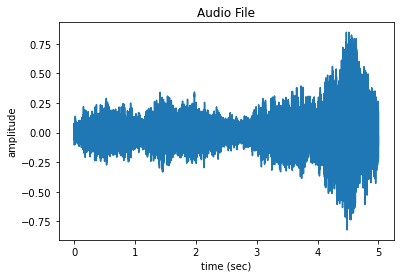

car_horn_1-24074-A-43.wav


In [ ]:
#@title #**Upload Audio File**
#@markdown Upload an audiofile, or use one of the default files. Note that only the first 10 seconds of the clip will be used. 


#Max length of an audio file is 10 seconds

UPLOAD_AUDIO = False #@param{type: 'boolean'}

if UPLOAD_AUDIO:

  uploaded = files.upload()

  if not uploaded:
    UPLOADED_FILE = ''
  elif len(uploaded) == 1:
    UPLOADED_FILE = list(uploaded.keys())[0]
    print(UPLOADED_FILE)
    track, _ = import_audio(UPLOADED_FILE, plot = True)
    
  else:
    raise AssertionError('Please upload one file at a time')

else:
  Default_audio_path = './AudioCLIP/demo/audio/'
  DEFAULT_AUDIO_FILE = 'car_horn_1-24074-A-43.wav' #@param ['coughing_1-58792-A-24.wav', 'alarm_clock_3-120526-B-37.wav', 'cat_3-95694-A-5.wav','thunder_3-144891-B-19.wav','car_horn_1-24074-A-43.wav','Crane Sounds Effect.mp3']
  UPLOADED_FILE = Default_audio_path+DEFAULT_AUDIO_FILE

  track, _ = import_audio(UPLOADED_FILE, plot = True)


audio = audio_transforms(track.reshape(1, -1))
Audio_ref = aclp.encode_audio(audio)

audio_embedding = torch.FloatTensor(Audio_ref).cuda().detach().clone()

## Audio Captioning

In [ ]:
#@title # **AudioCLIP-based querying**
#@markdown This is the AudioCLIP search method as detailed in the paper.

import random
#=====================#
# Get descriptor lists
#=====================#
# Colors
Color_Labels = read_txt('colors-list.txt')
#Music Genres
Genre_Labels = read_txt('genres modified.txt')

#=================================#
# Define describe audio function
#=================================#

def Describe_Audio(Text_Labels, audio = audio, Top_K = 3, sample_size = 50,display = True): 

# Adapted from: https://github.com/AndreyGuzhov/AudioCLIP/blob/master/demo/AudioCLIP.ipynb


  #Random sample from the text label so you get a different result each time
  Text_Labels = random.sample(Text_Labels, min(len(Text_Labels),sample_size))

  #==========================#
  # Get AudioCLIP embeddings
  #==========================#

  #Text
  ((_, _, text_features), _), _ = aclp(text=Text_Labels)
  # Audio
  ((audio_features, _, _), _), _ = aclp(audio=audio)

  #--------------------#
  # Normalize Embeddings
  #--------------------#
  text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)

  #--------------------#
  # Get Logit scales
  #--------------------#

  # Outputs of the text-, image- and audio-heads are made consistent using dedicated scaling terms for each pair of modalities. 
  # The scaling factors are clamped between 1.0 and 100.0.

  # audio and text
  scale_audio_text = torch.clamp(aclp.logit_scale_at.exp(), min=1.0, max=100.0)

  #----------------------#
  # Get cosine similarity
  #----------------------#

  # Equivalent to the matrix multiplication of audio features and text features, scaled by scale_audio_text

  logits_audio_text = scale_audio_text * audio_features @ text_features.T

  #---------------------------#
  # Get Softmax Probabilities
  #---------------------------#

  confidence = logits_audio_text.softmax(dim=1)
  for audio_idx in range(len([audio])):
      # acquire Top-k most similar results
      conf_values, ids = confidence[audio_idx].topk(Top_K)

      Top_words = [Text_Labels[i] for i in ids]
      Top_words_confidences = [i for i in conf_values]

      if display:
        # format output strings
        results = ', '.join([f'{Text_Labels[i]} ({v:06.2%})' for v, i in zip(conf_values, ids)])
        print(results)

  return Top_words, Top_words_confidences


In [ ]:
#@title # **Music Captioning Model (MusCaps)**
#@markdown This is the pretrained MusCaps model as detailed in the paper.
#===========================#
#import MusCap dependencies
#===========================#

if USE_MUSCAP:
  sys.path.append('./muscaps')
  import os
  import torch
  from omegaconf import OmegaConf
  import json
  from tqdm import tqdm
  import argparse

  from muscaps.utils.vocab import Vocabulary
  from muscaps.scripts.eval import Evaluation
  from muscaps.utils.utils import get_root_dir
  from muscaps.utils.text_decoder import GreedyDecoder, BeamSearchDecoder
  from muscaps.utils.logger import Logger
  from muscaps.caption_evaluation_tools import eval_metrics
  from muscaps.scripts.caption import Captioning


  experiment_id = 'Final MusCap Model'
  config = OmegaConf.load(os.path.join(get_root_dir(), "save/experiments/{}/config - MusCap Model.yaml".format(experiment_id)))

  logger =  Logger(config)
  device = torch.device(0)

  path_to_model = os.path.join(config.env.experiments_dir,
                                  experiment_id,
                                            "best_model.pth.tar")

  token_freq_dict = json.load(open(logger.vocab_path, 'r'))
  vocab = Vocabulary(tokens=None, token_freq=token_freq_dict)

  # The config will be set to greedy decoding to save on memory
  if config.model_config.inference_type == "greedy":
    text_decoder = GreedyDecoder(
        vocab, config)
  elif config.model_config.inference_type == "beam_search":
      text_decoder = BeamSearchDecoder(vocab, config)

  #Create the evaluation object   
  evaluation = Captioning(config, logger, experiment_id)
  print('done')

  #==================================#
  # Define MusCap Captioning function
  #==================================#

  def Get_MusCap_Caption(track, evaluation = evaluation): 
    """
    Use the pretrained MusCap model to create a caption for the audio file
    
    #inputs:
    # track: The audio track in the form of a list or np array
    # evaluation: the MusCap evaluation object. Will have been generated earlier in the code
    
    # Return: The caption in string form
    """
    
    # Convert track to np array
    track = np.array(track)

    # use the evaluate object to get the resulting caption in word index form
    res = evaluation.predict_caption(torch.from_numpy(track).view(1,-1),torch.tensor([len(torch.from_numpy(track))]) )

    # transform the word index list into words using the vocabulary inside the evaluation object
    Caption = [vocab.idx2word[r] for r in res]
    
    # remove start and end of sentences tokens 
    Caption = [word for word in Caption if word not in ['<sos>','<eos>']]

    return ' '.join(Caption)


if USE_MUSCAP:
  MusCap_Caption = Get_MusCap_Caption(track, evaluation)
  MusCap_Caption

100%|█████████▉| 399999/400000 [00:42<00:00, 9515.88it/s]


Loading dataset
Building model
done


./muscaps/muscaps/models/cnn_attention_lstm.py:60: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  audio_len = audio_len // self.audio_encoder.input_length


In [ ]:
#@title # **Combine Text Captions**

#========================#
# Attach New Text prompts
#========================#

if USE_TEXT_PROMPTS == False:
  prompts = []

if DESCRIBE_AUDIO:

  if USE_COLORS:
    TEXT_DESCRIPTION, _ = Describe_Audio(Text_Labels = Color_Labels, 
                                         audio = audio,
                                         Top_K = N_COLORS)
    prompts += TEXT_DESCRIPTION

  if USE_GENRES:
    TEXT_DESCRIPTION, _ = Describe_Audio(Text_Labels = Genre_Labels, 
                                         audio = audio,
                                         Top_K = N_GENRES)
    prompts += TEXT_DESCRIPTION

  if USE_MUSCAP:
    prompts += [MusCap_Caption]

if len(prompts) == 0:
  prompts = ['A frightening monster trying to scare you']

print_txt_prompt(prompts)

text prompt 1: A car in the style of blade runner
text prompt 2: a machine is running and then off in the background


## Generative Loop

  0%|          | 0/1000 [00:00<?, ?it/s]

Batch 0, step 0, output 0:


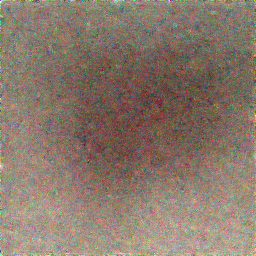

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Predicted caption: the colors in the series paint.
Batch 0, step 100, output 0:


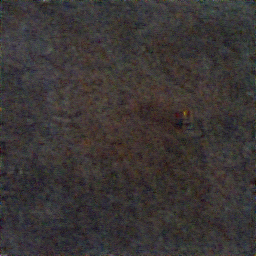

Predicted caption: this is a close up of the texture on the floor.
Batch 0, step 200, output 0:


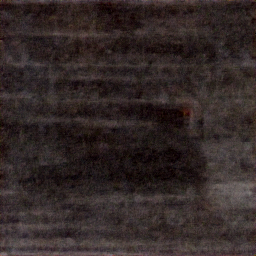

Predicted caption: the texture of the concrete.
Batch 0, step 300, output 0:


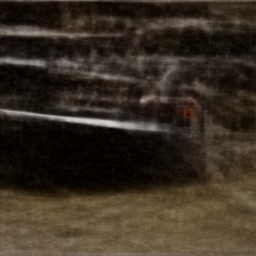

Predicted caption: this photo was taken in the middle of the night.
Batch 0, step 400, output 0:


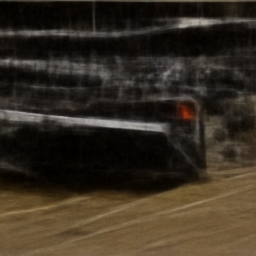

Predicted caption: a car in the rain.
Batch 0, step 500, output 0:


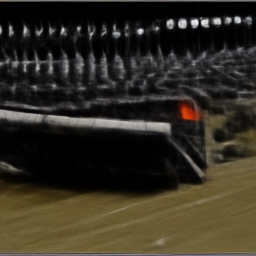

Predicted caption: the car in the middle of the race.
Batch 0, step 600, output 0:


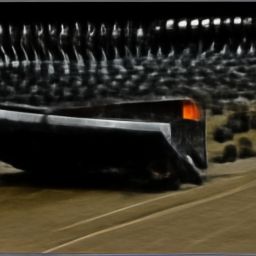

Predicted caption: 3d model of a car.
Batch 0, step 700, output 0:


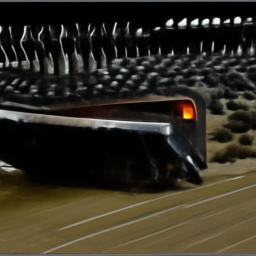

Predicted caption: how to draw a car with a pencil step by step - photo #.
Batch 0, step 800, output 0:


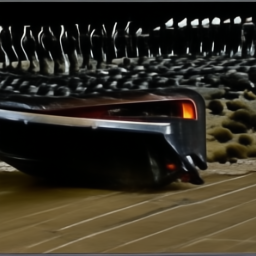

Predicted caption: how to build a car from scratch : part.
Batch 0, step 900, output 0:


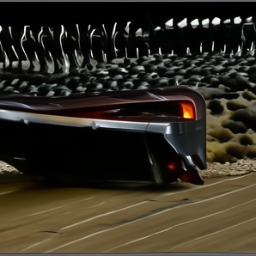

Predicted caption: 3d model of a car.
Batch 0, step 999, output 0:


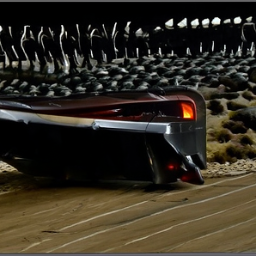

Predicted caption: concept cars of the future.


In [ ]:
#@title #**Generation Time!**
#@markdown Once done, this will output a folder and zip file with your inputted file name. This will contain the images printed during generation time, the CLIPCap captions, and the text prompt/s.

def do_run():
    if seed is not None:
        torch.manual_seed(seed)

    make_cutouts = MakeCutouts(clip_size, cutn)
    side_x = side_y = model_config['image_size']

    target_embeds, weights = [], []

    for prompt in prompts:
        txt, weight = parse_prompt(prompt)
        target_embeds.append(clip_model.encode_text(clip.tokenize(txt).to(device)).float())
        weights.append(weight)

    for prompt in image_prompts:
        path, weight = parse_prompt(prompt)
        img = Image.open(fetch(path)).convert('RGB')
        img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = clip_model.encode_image(normalize(batch)).float()
        target_embeds.append(embed)
        weights.extend([weight / cutn] * cutn)

    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()

    init = None
    if init_image is not None and init_image != '':
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

    cur_t = None

    def cond_fn(x, t, out, y=None):
        n = x.shape[0]
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
        image_embeds = clip_model.encode_image(clip_in).float()
        
        # Text Loss
        dists_Txt = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
        dists_Txt = dists_Txt.view([cutn, n, -1])
        Txt_losses = dists_Txt.mul(weights).sum(2).mean(0)
        
        # Audio Loss
        dists_Audio = spherical_dist_loss(image_embeds.unsqueeze(1), audio_embedding.squeeze(0))
        dists_Audio = dists_Audio.view([cutn, n, -1])
        Audio_losses = dists_Audio.mul(weights).sum(2).mean(0)
        
        #Combo of text and audio losses
        Losses_combo = (LOSS_PROP_TEXT)*Txt_losses.sum() + (1-LOSS_PROP_TEXT)*Audio_losses.sum()

        tv_losses = tv_loss(x_in)
        range_losses = range_loss(out['pred_xstart'])

        loss = Losses_combo.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale + range_losses.sum() * range_scale
        # loss = losses_Txt.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale + range_losses.sum() * range_scale
        if init is not None and init_scale:
            init_losses = lpips_model(x_in, init)
            loss = loss + init_losses.sum() * init_scale
        return -torch.autograd.grad(loss, x)[0] #modify to add loss

    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive

    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1

        samples = sample_fn(
            model,
            (batch_size, 3, side_y, side_x),
            clip_denoised=False,
            model_kwargs={},
            cond_fn=cond_fn,
            progress=True,
            skip_timesteps=skip_timesteps,
            init_image=init,
            randomize_class=True,
            cond_fn_with_grad=True,
        )

        pred_cap_list = []
        img_ind = 1
        for j, sample in enumerate(samples):
            cur_t -= 1
    
            if j % 100 == 0 or cur_t == -1:
                for k, image in enumerate(sample['pred_xstart']):
                    # filename = f"{FILE_NAME}_{i+1 * batch_size + k:05}.png"

                    filename = f"./{FILE_NAME}/{FILE_NAME}_{img_ind}.png"
                    TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    display.display(display.Image(filename))
                    CC_Caption = ClipCap_Captionizer(TF.to_pil_image(image.add(1).div(2).clamp(0, 1)))
                    pred_cap_list.append(CC_Caption)

                    img_ind +=1
        
        #Save predicted prompts into a text file
        filename_txt = f"./{FILE_NAME}/{FILE_NAME}_PredCaptions.txt"
        save_list(filename_txt, pred_cap_list)

        filename_prompts = f"./{FILE_NAME}/{FILE_NAME}_Prompts.txt"
        save_list(filename_prompts, prompts )

        #Zip things up
        shutil.make_archive(f"{FILE_NAME}_Generations", 'zip', f"{FILE_NAME}")

gc.collect()
do_run()